In [1]:
try:
    import numpy as np
except:
    %pip install numpy
      
import pandas as pd
import matplotlib.pyplot as plt
import latexify as lt
import scipy.signal as signal

#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

In [2]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
#%matplotlib notebook
#from ipywidgets import *
#np.set_printoptions(precision=3)

In [4]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

In [4]:
#df = pd.read_csv('data.csv', sep=' ',names=['Angle','Distance','Quality'])

In [29]:
df = pd.read_csv('data/29-05-2022-1cm-vibration-29.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
df.head()

New_Scan  Quality       Angle  Distance
0     False       15  286.218750      0.00
1     False       15   32.265625      0.00
2     False       15   33.906250    254.25
3     False       15   36.140625    258.00
4     False       15   36.687500    262.00

In [79]:
#stationary signal
df = pd.read_csv('data/stationary.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
df.head()

New_Scan  Quality       Angle  Distance
0     False        6  313.125000       0.0
1     False       15   50.234375       0.0
2     False       15   51.515625     721.5
3     False       15   59.078125       0.0
4     False       15   61.562500     121.5

Sampling Rate for data collected between 60 deg and 120 deg is 331.00


(0.0, 10.0)

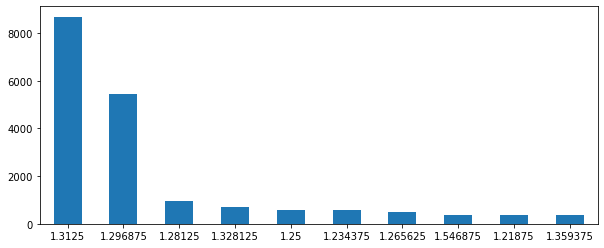

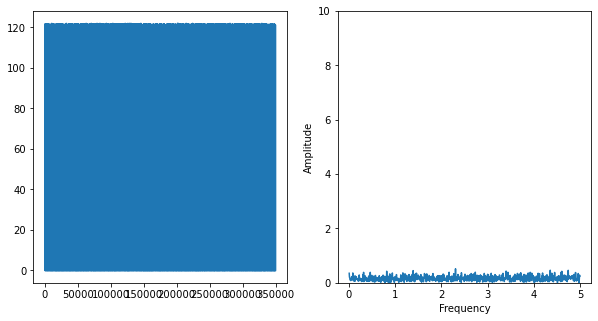

In [80]:
startAngle = 60
endAngle = 120
elTime = 180 #in 3 minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(selectedData['Distance'])
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = round(len(F)/max(F))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')
ax[1].set_ylim(0,10)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))

Sampling Rate for data collected between 80 deg and 83 deg is 15.00


(0.0, 10.0)

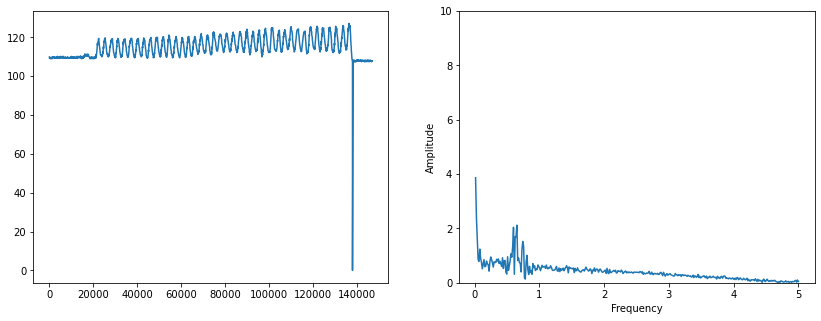

In [114]:
#9cm away from the sensor
#metronome 40 signal. 40/60 = 0.66 Hz
df = pd.read_csv('data/metronome-40.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 80 #60
endAngle = 83 #120
elTime = 75 #in 3 minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)


fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(selectedData['Distance'])
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = round(len(F)/max(F))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')
ax[1].set_ylim(0,10)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))

Sampling Rate for data collected between 85 deg and 90 deg is 33.00


(0.0, 1.0)

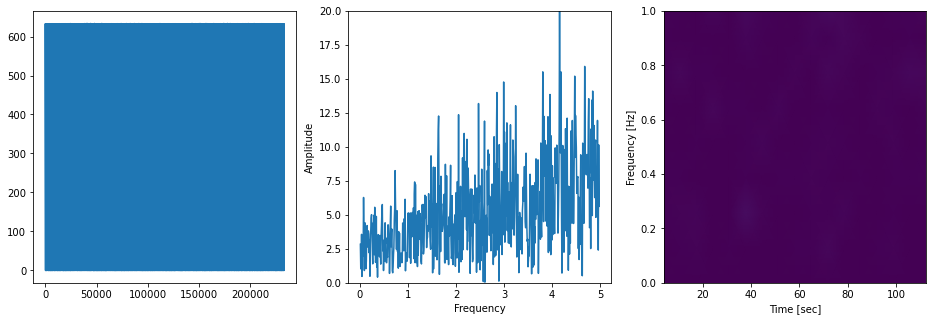

In [57]:
#stationary
df = pd.read_csv('data/stationary-2.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 85
endAngle = 90
elTime = 120 #in 2 minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)


fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(selectedData['Distance'])
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = round(len(F)/max(F))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')
ax[1].set_ylim(0,20)


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))

Sampling Rate for data collected between 85 deg and 87 deg is 16.00


(0.0, 1.0)

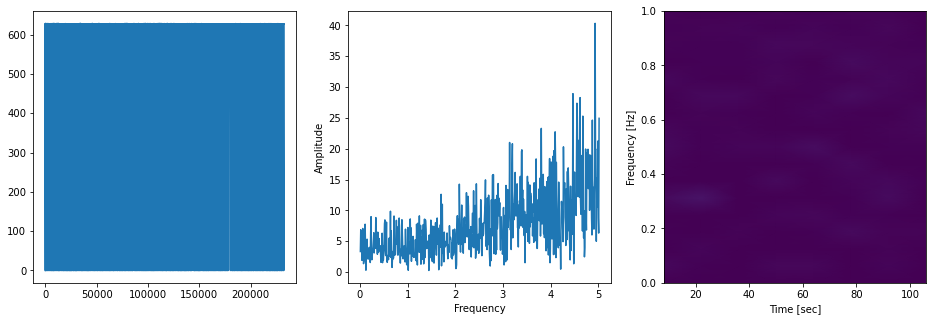

In [56]:
#60cm away from the sensor
#stationary
df = pd.read_csv('data/stationary-3-no-fan.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 85
endAngle = 87
elTime = 120 #in 2 minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)


fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(selectedData['Distance'])
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = round(len(F)/max(F))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')

f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].set_ylim(0,20)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))

Sampling Rate for data collected between 85 deg and 87 deg is 11.00


(0.0, 1.0)

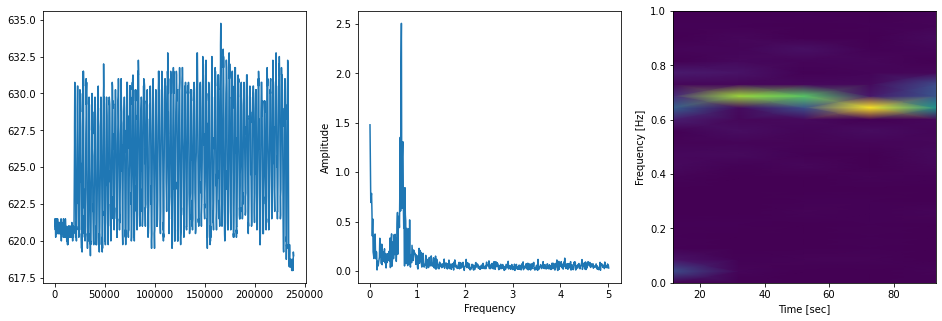

In [55]:
df = pd.read_csv('data/metronome-40-2.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 85
endAngle = 87
elTime = 123 #in 2.04 minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)


fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(selectedData['Distance'])
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = round(len(F)/max(F))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')

f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].set_ylim(0,20)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))

### Expt With Aryan

Sampling Rate for data collected between 90 deg and 92 deg is 11.00


(0.0, 1.0)

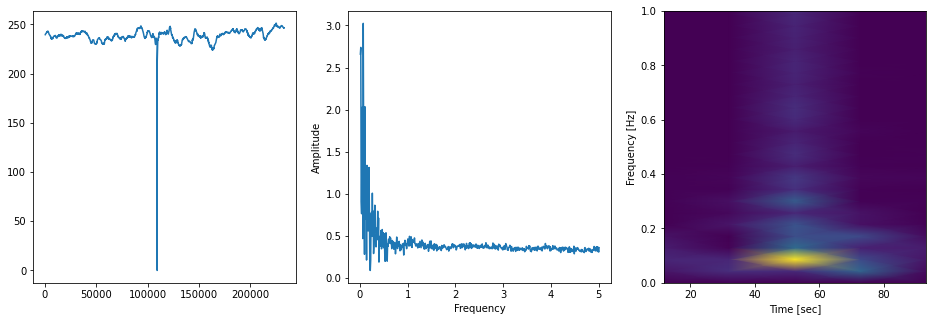

In [60]:
#distance: 230mm (below belly) [120s]
#angle: 60 to 120 degree


df = pd.read_csv('data/aryan-standing-230cm-away.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 90
endAngle = 92
elTime = 120 #in 2. minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)


fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(selectedData['Distance'])
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].set_ylim(0,20)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))

Sampling Rate for data collected between 86 deg and 88 deg is 11.00


(0.0, 1.0)

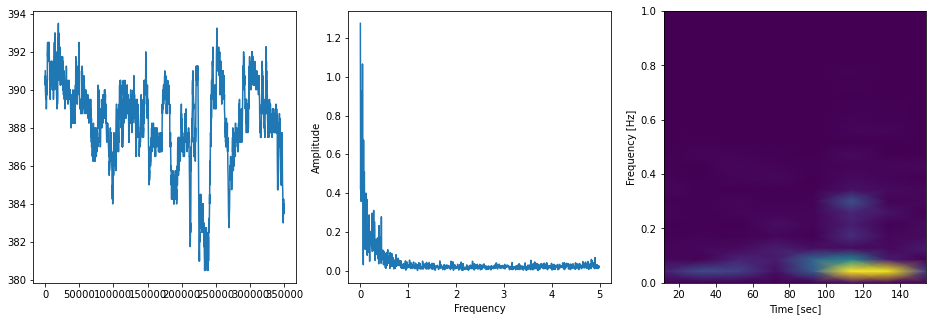

In [59]:
#distance: 370cm (chest-diaphragram) [180s]
#angle: 72 to 100 degree

df = pd.read_csv('data/aryan-standing-370cm.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 86
endAngle = 88
elTime = 180 #in 3. minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)


fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(selectedData['Distance'])
#ax[0].set_ylim(400,410)
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].set_ylim(0,20)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


## mm Experiments

In [4]:
#distance 200 cm
#angle: 90
#time: 240s
startAngle = 89
endAngle = 90
elTime = 240
mean_dist = []

In [11]:
df = pd.read_csv('mm-200.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
mean_dist.append(selectedData['Distance'].mean())

In [13]:
gt = [192,194,196,198,200]

D:\anaconda3\lib\_collections_abc.py:941: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


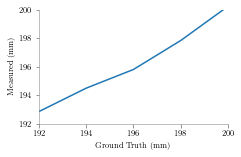

In [18]:
lt.latexify()
fig, ax = plt.subplots(1,1)
ax.plot(gt,mean_dist)
ax.set_ylabel('Measured (mm)')
ax.set_xlabel('Ground Truth (mm)')
ax.set_ylim(192,200)
ax.set_xlim(192,200)
lt.format_axes(ax)
plt.savefig('gt-vs-measured.pdf',bbox_inches='tight')

# Breathing Experiments

### Stationary Chair at 90 deg For 6 Minutes

Sampling Rate for data collected between 89 deg and 91 deg is 13.00


Text(0.5, 0, 'Time [sec]')

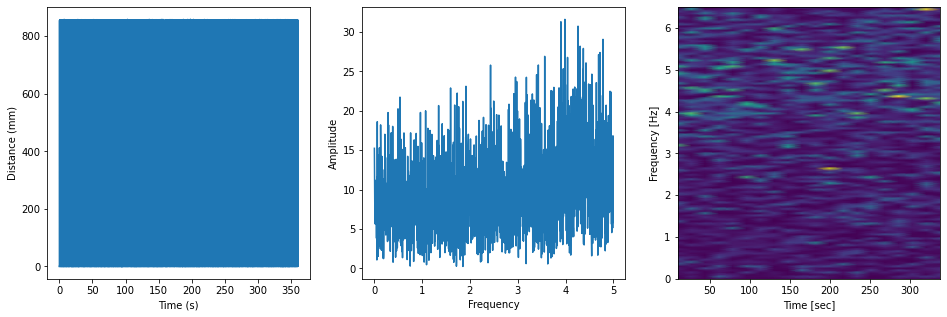

In [14]:
#angle: 89 to 90
df = pd.read_csv('breathing-stationary.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 89
endAngle = 91
elTime = 360 #in 5. minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]

fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
#ax[2].set_ylim(0,1)
#ax[1].set_ylim(0,20)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


### Chest Displacement at 40 BPM at 85-90 deg For 4 Minutes

Sampling Rate for data collected between 85 deg and 86 deg is 6.00


Text(0.5, 0, 'Time [sec]')

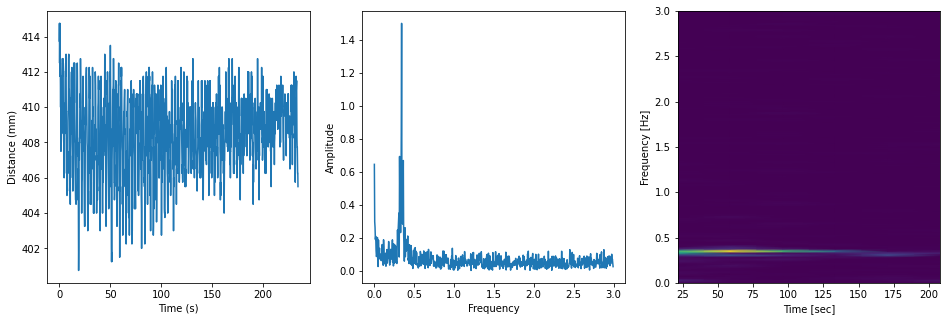

In [13]:
#angle: 89 to 90
df = pd.read_csv('beathing-40bpm.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 85
endAngle = 86
elTime = 240 #in 4. minutes
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]

fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[1].plot(F[1:resolution*5],A[1:resolution*5])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
#ax[2].set_ylim(0,1)
#ax[1].set_ylim(0,20)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


### Tripod Alignment 260-280 deg For 6 Minutes

Sampling Rate for data collected between 270 deg and 271 deg is 5.00


(0.0, 1.0)

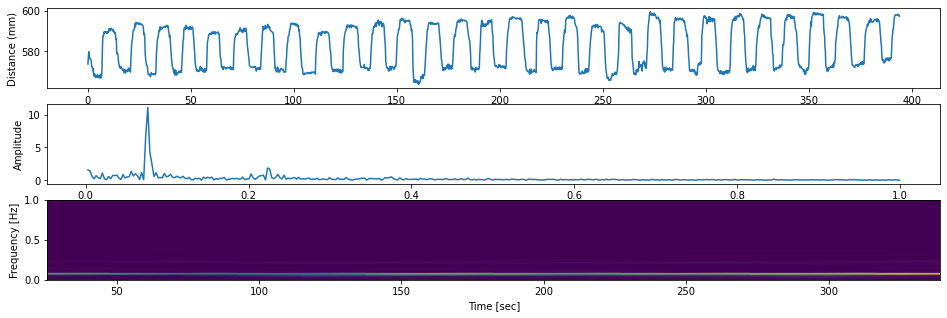

In [12]:
#10 BPM with Aryan sitting on chair
df = pd.read_csv('tripod/2.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 270
endAngle = 271
elTime = 360 #6 minutes + buffer
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]

fig, ax = plt.subplots(3,1,figsize=(16,5))
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[1].plot(F[1:resolution*1],A[1:resolution*1])
#ax[1].plot(F[1:],A[1:])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 270 deg and 271 deg is 10.00


(0.0, 1.0)

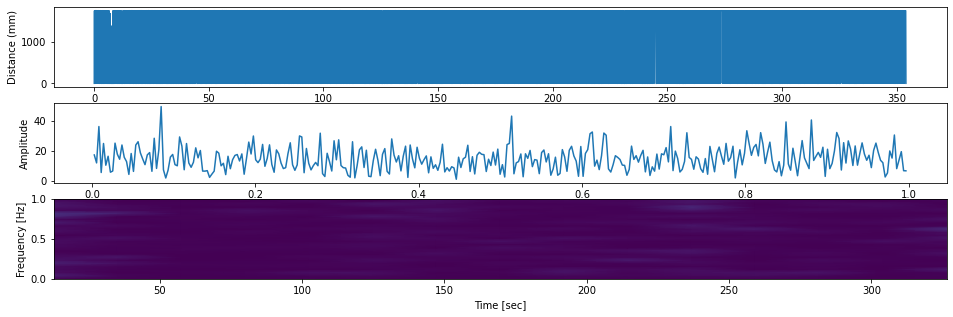

In [13]:
#no person, empty chair
df = pd.read_csv('tripod/3.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 270
endAngle = 271
elTime = 360 #6 minutes + buffer
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]

fig, ax = plt.subplots(3,1,figsize=(16,5))
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[1].plot(F[1:resolution*1],A[1:resolution*1])
#ax[1].plot(F[1:],A[1:])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 270 deg and 285 deg is 82.00


(0.0, 1.0)

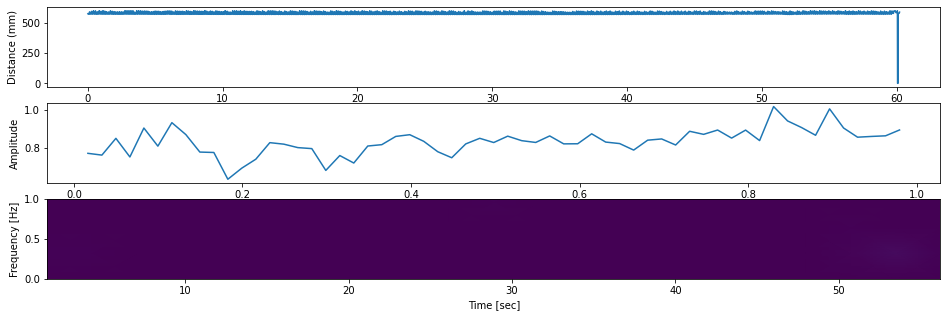

In [16]:
# breathing hold for 1 minute
#angle: 89 to 90
df = pd.read_csv('tripod/no-breathing-2.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 270
endAngle = 285
elTime = 60 #1 minutes + buffer
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]

fig, ax = plt.subplots(3,1,figsize=(16,5))
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[1].plot(F[1:resolution*1],A[1:resolution*1])
#ax[1].plot(F[1:],A[1:])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 270 deg and 282 deg is 108.00


(0.0, 1.0)

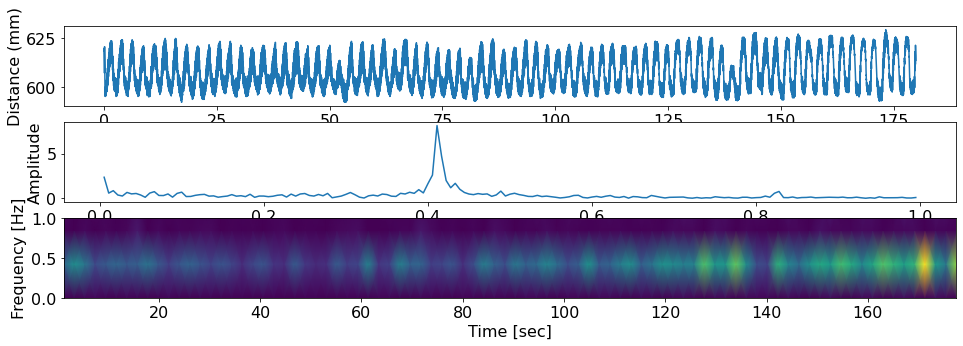

In [73]:
# 30 BPM with Aryan sitting on chair
#angle 250 - 280
#time: 1 minutes

# breathing hold for 1 minute
#angle: 89 to 90
df = pd.read_csv('tripod/30-BPM.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 270
endAngle = 282
elTime = 180 #1 minutes + buffer
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]

fig, ax = plt.subplots(3,1,figsize=(16,5))
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)
F,A = compute_fft(np.array(selectedData['Distance']), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[1].plot(F[1:resolution*1],A[1:resolution*1])
#ax[1].plot(F[1:],A[1:])
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency')


f, t, Sxx = signal.spectrogram(selectedData['Distance'], fs = sr, nperseg=256)
ax[2].pcolormesh(t, f, Sxx, shading='gouraud')
ax[2].set_ylabel('Frequency [Hz]')
ax[2].set_xlabel('Time [sec]')
ax[2].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 225 deg and 230 deg is 27.00


Text(0.5, 0, 'Frequency')

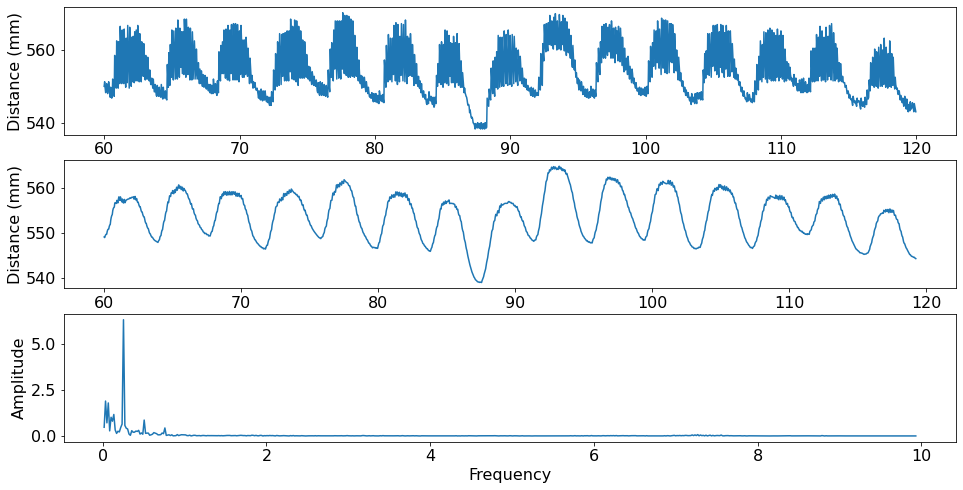

In [17]:
# RPLIDAR Kept in such a way so as to make a diagonal mark on chest 
# 30 BPM with Aryan sitting on chair
#angle 250 - 280
#time: 5 minutes

# breathing hold for 5 minute
#angle: 210 to 240
df = pd.read_csv('tripod/tilted-1.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 225
endAngle = 230
elTime = 300 
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 60
timeUntil =  120#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 20
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(3,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*10],A[1:resolution*10])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


#f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=512)
#ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
#ax[3].set_ylabel('Frequency [Hz]')
#ax[3].set_xlabel('Time [sec]')
#ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 190 deg and 200 deg is 54.00


Text(0.5, 0, 'Frequency')

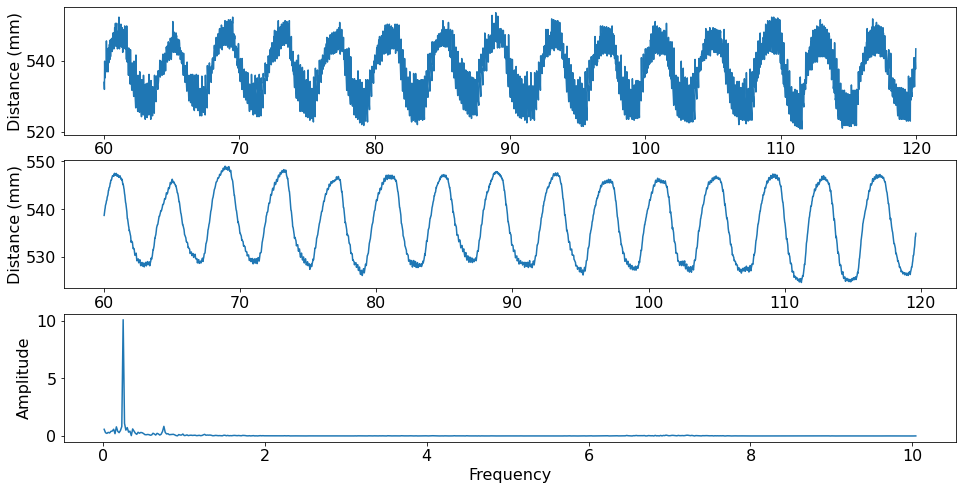

In [15]:
# RPLIDAR Kept in such a way so as to make a vertical mark on chest 
# 30 BPM with Aryan sitting on chair
#angle 180 - 210
#time: 4 minutes

df = pd.read_csv('tripod/vertical.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 190
endAngle = 200
elTime = 240 
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 60
timeUntil =  120#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 20
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(3,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*10],A[1:resolution*10])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


#f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=512)
#ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
#ax[3].set_ylabel('Frequency [Hz]')
#ax[3].set_xlabel('Time [sec]')
#ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Sampling Rate for data collected between 175 deg and 185 deg is 54.00


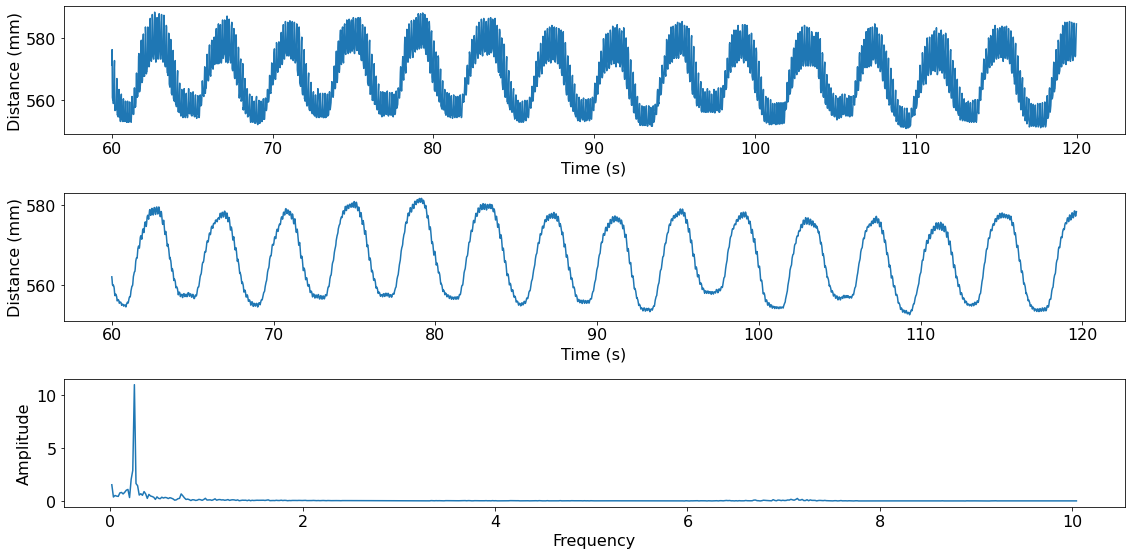

In [14]:
# RPLIDAR Kept in such a way so as to make a horizontal mark on chest 
# 30 BPM with Aryan sitting on chair
#angle 180 - 210
#time: 4 minutes

df = pd.read_csv('tripod/horizontal.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 175
endAngle = 185
elTime = 240 
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 60
timeUntil =  120#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 20
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(3,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*10],A[1:resolution*10])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


#f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=512)
#ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
#ax[3].set_ylabel('Frequency [Hz]')
#ax[3].set_xlabel('Time [sec]')
#ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))
fig.tight_layout()

Sampling Rate for data collected between 260 deg and 262 deg is 11.00


Text(0.5, 0, 'Frequency')

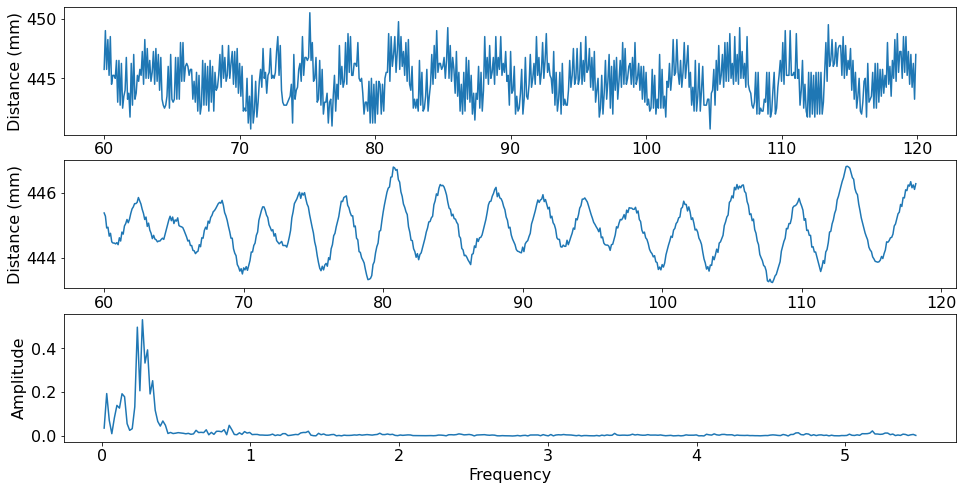

In [18]:
# RPLIDAR Kept in such a way so as to make a horizontal mark on chest 
# No BPM but tidal breathing
#angle 260 - 275
#time: 6 minutes

df = pd.read_csv('tripod/no-bpm-1.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])

startAngle = 260
endAngle = 262
elTime = 360  
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 60
timeUntil =  120#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 20
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(3,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*10],A[1:resolution*10])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


#f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=512)
#ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
#ax[3].set_ylabel('Frequency [Hz]')
#ax[3].set_xlabel('Time [sec]')
#ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 260 deg and 262 deg is 10.00


Text(0.5, 0, 'Frequency')

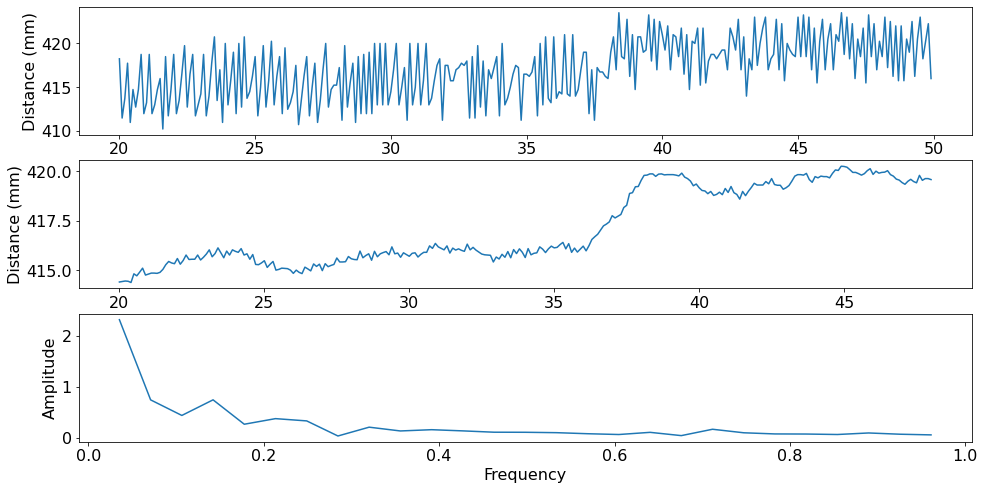

In [19]:
# RPLIDAR Kept in such a way so as to make a horizontal mark on chest 
# No tidal breahthing but breathe hold
#angle 260 - 275
#time: 1 minutes

df = pd.read_csv('tripod/no-breathing-1.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 260
endAngle = 262
elTime = 70  
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 20
timeUntil =  50#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 20
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(3,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*1],A[1:resolution*1])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


#f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=256)
#ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
#ax[3].set_ylabel('Frequency [Hz]')
#ax[3].set_xlabel('Time [sec]')
#ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 270 deg and 280 deg is 55.00


Text(0.5, 0, 'Frequency')

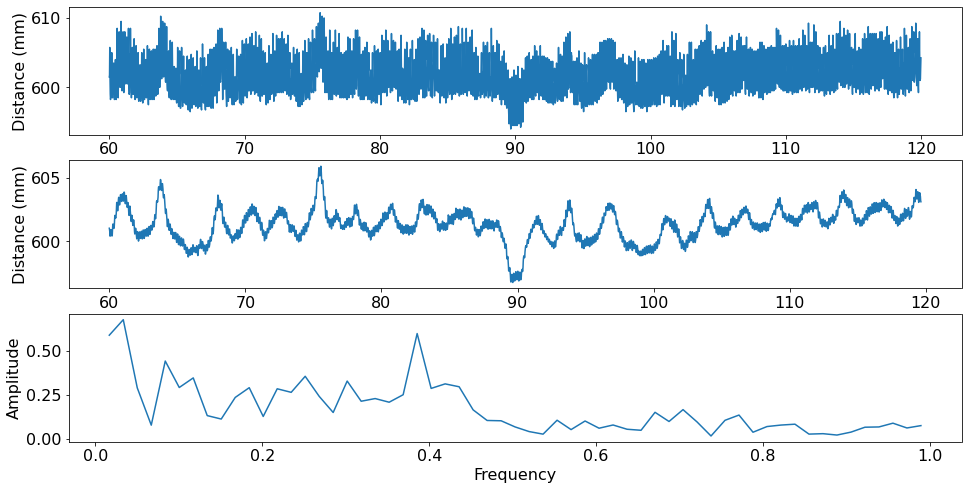

In [58]:
# RPLIDAR Kept in such a way so as to make a horizontal mark on chest 
# aabhas
# tidal breathing
#angle 270 - 280
#time: 6 minutes

df = pd.read_csv('tripod/aabhas-tidal.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 270
endAngle = 280
elTime = 360  
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 60
timeUntil =  120#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 20
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(3,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*1],A[1:resolution*1])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


#f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=256)
#ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
#ax[3].set_ylabel('Frequency [Hz]')
#ax[3].set_xlabel('Time [sec]')
#ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 270 deg and 275 deg is 27.00


(0.0, 1.0)

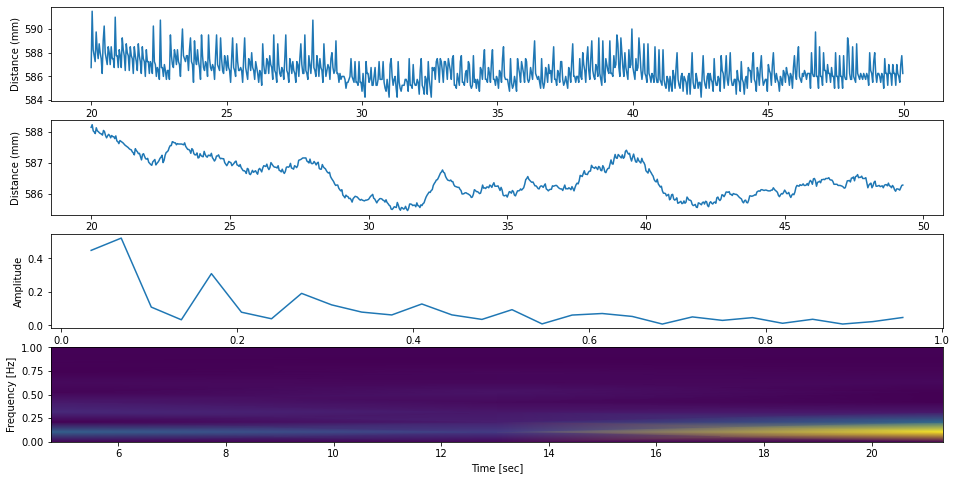

In [52]:
# RPLIDAR Kept in such a way so as to make a horizontal mark on chest 
# aabhas
# hold breathe
#angle 270 - 280
#time: 1 minutes

df = pd.read_csv('tripod/aabhas-no-breathe.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 270
endAngle = 275
elTime = 60  
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 20
timeUntil =  50#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 20
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(4,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*1],A[1:resolution*1])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=256)
ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
ax[3].set_ylabel('Frequency [Hz]')
ax[3].set_xlabel('Time [sec]')
ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 175 deg and 179 deg is 21.00


(0.0, 1.0)

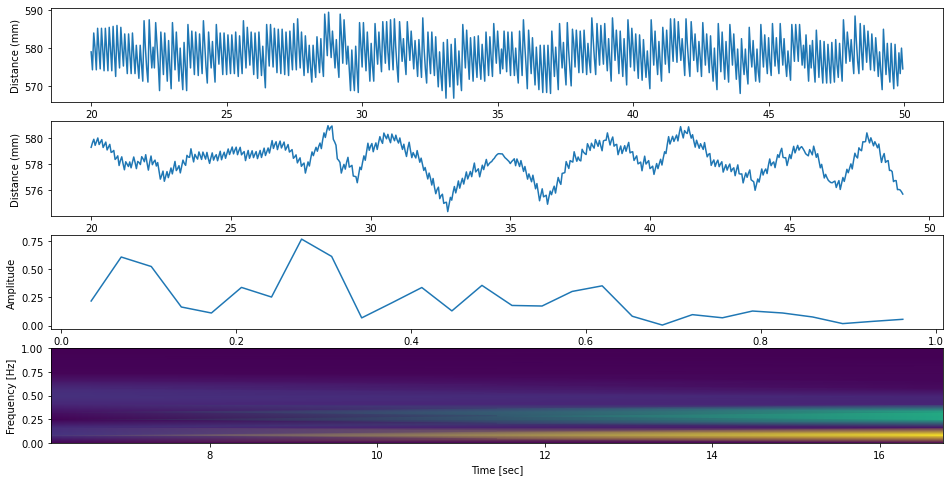

In [57]:
# RPLIDAR Kept in such a way so as to make a vertical mark on chest 
# aabhas
# tidal breathing
#angle 168 - 180
#time: 5 minutes

df = pd.read_csv('tripod/aabhas-vertical.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 175
endAngle = 179
elTime = 300  
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 20
timeUntil =  50#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 20
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(4,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*1],A[1:resolution*1])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=256)
ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
ax[3].set_ylabel('Frequency [Hz]')
ax[3].set_xlabel('Time [sec]')
ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


Sampling Rate for data collected between 279 deg and 282 deg is 17.00


Text(0.5, 0, 'Frequency')

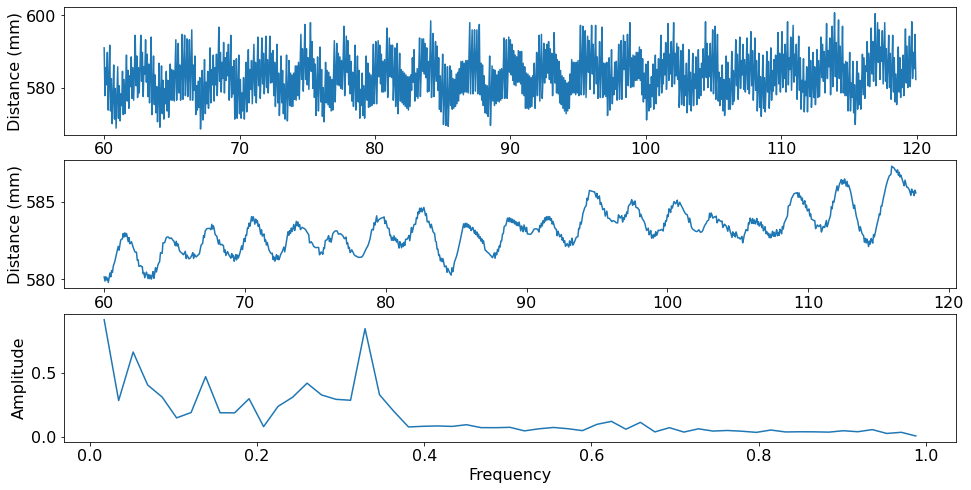

In [56]:
# RPLIDAR sleeping position 
# rishiraj
# tidal breathing
#angle 280 - 285
#time: 6 minutes

df = pd.read_csv('rr1.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
#df.head()
startAngle = 279#####279
endAngle = 282 ####282
elTime = 360  
sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
print("Sampling Rate for data collected between {} deg and {} deg is {:.2f}".format(startAngle, endAngle,sr))


#choose time stamp of data.
startTime = 60
timeUntil =  120#in seconds
selectedData = selectedData[startTime*sr:sr*timeUntil]
t = t[startTime*sr:sr*timeUntil]

#print the angle diference between subsequent samples
#pd.Series(np.diff(selectedData['Angle'])).value_counts().iloc[:10].plot(figsize=(10,4),kind='bar',rot=0)

#smooth the signal
filter_window_size = 40
dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
t_ = t[:-filter_window_size+1]
#fig, ax = plt.subplots(1,1,figsize=(16,5))
#ax.plot(t,dist)


fig, ax = plt.subplots(3,1,figsize=(16,8))
#plot raw signal
ax[0].plot(t,selectedData['Distance'])
ax[0].set_ylabel('Distance (mm)')
ax[0].set_xlabel('Time (s)')
#ax[0].set_ylim(400,410)
#ax[0].set_xlim(100,150)

#plot filtered signal
ax[1].plot(t_,dist)
ax[1].set_ylabel('Distance (mm)')
ax[1].set_xlabel('Time (s)')

#plot frequency response
F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
resolution = int(round(len(F)/max(F)))
ax[2].plot(F[1:resolution*1],A[1:resolution*1])
#ax[2].plot(F[1:],A[1:])
ax[2].set_ylabel('Amplitude')
ax[2].set_xlabel('Frequency')


#f, t_s, Sxx = signal.spectrogram(dist, fs = sr, nperseg=256)
#ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
#ax[3].set_ylabel('Frequency [Hz]')
#ax[3].set_xlabel('Time [sec]')
#ax[3].set_ylim(0,1)
#ax[1].annotate(F[np.argmax(A[1:])+1],(F[np.argmax(A[1:])+1],A[np.argmax(A[1:])+1]),(F[np.argmax(A[1:])+5],A[np.argmax(A[1:])+5]))


## LIDAR auto detect frequency where breathing can be captured

In [ ]:
#setting up the peak detection instances
#real_time_peak_detection(array, lag, threshold, influence)

Breathing found between 25 and 30
x and y must have same first dimension, but have shapes (357,) and (39,)
Breathing found between 40 and 45
x and y must have same first dimension, but have shapes (359,) and (357,)
Breathing found between 55 and 60
Breathing found between 60 and 65
Breathing found between 65 and 70
Breathing found between 105 and 110
x and y must have same first dimension, but have shapes (355,) and (359,)
Breathing found between 110 and 115
x and y must have same first dimension, but have shapes (352,) and (355,)
Breathing found between 125 and 130
x and y must have same first dimension, but have shapes (359,) and (352,)
Breathing found between 145 and 150
Breathing found between 150 and 155
Breathing found between 185 and 190
Breathing found between 195 and 200
Breathing found between 200 and 205
x and y must have same first dimension, but have shapes (358,) and (359,)
Breathing found between 205 and 210
x and y must have same first dimension, but have shapes (354,) 

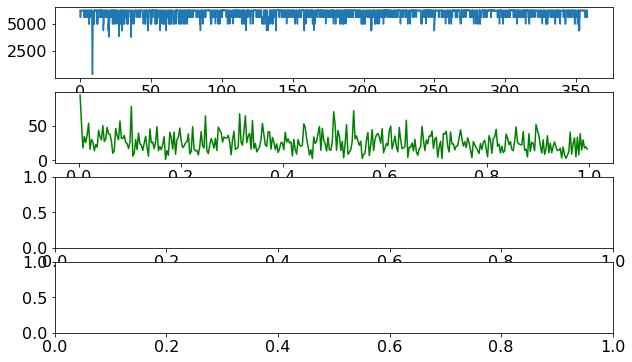

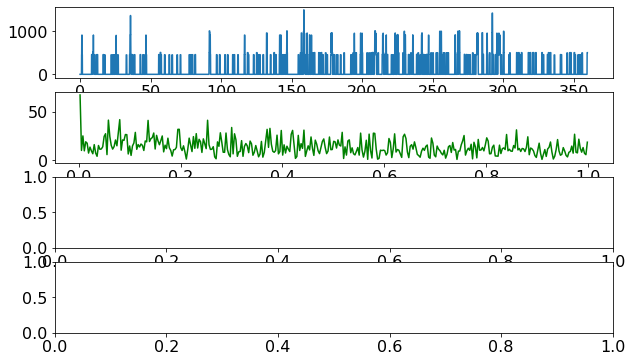

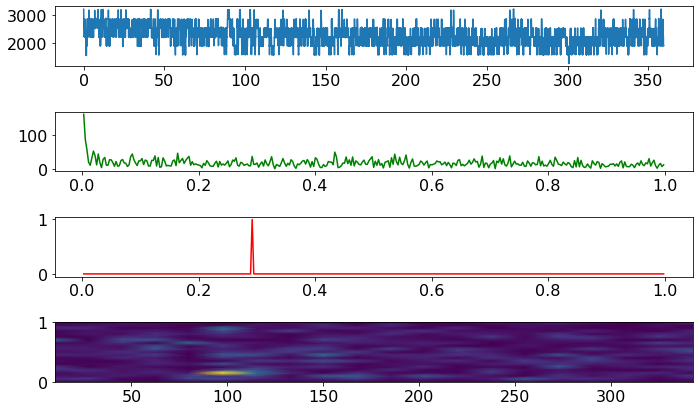

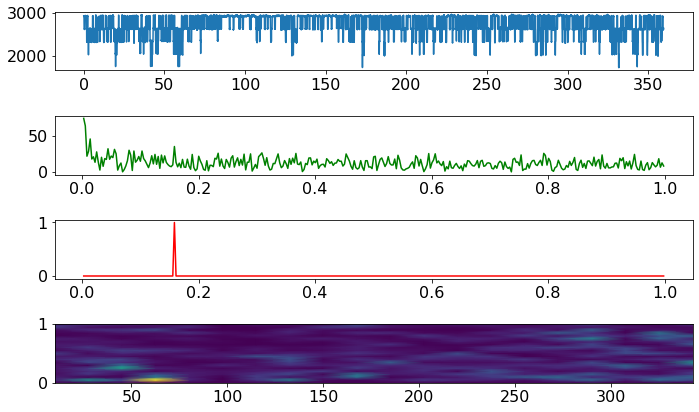

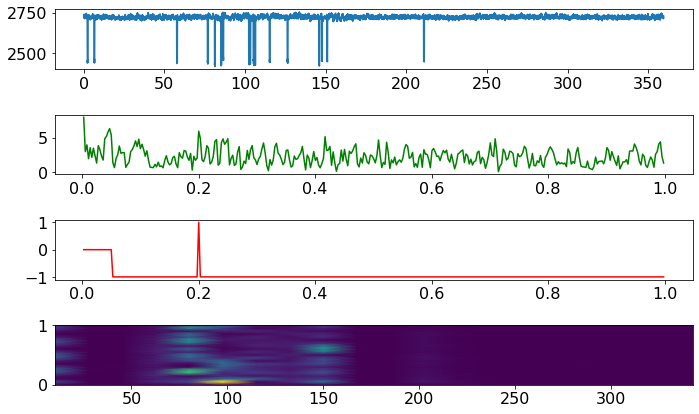

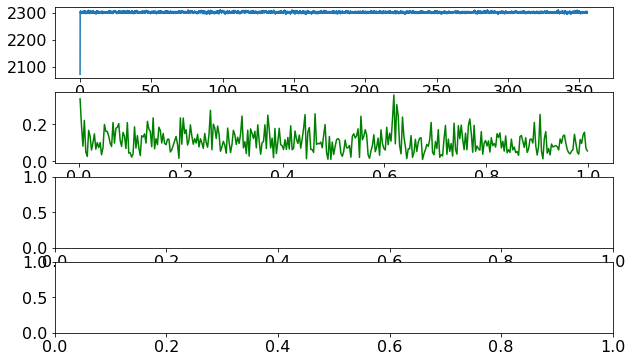

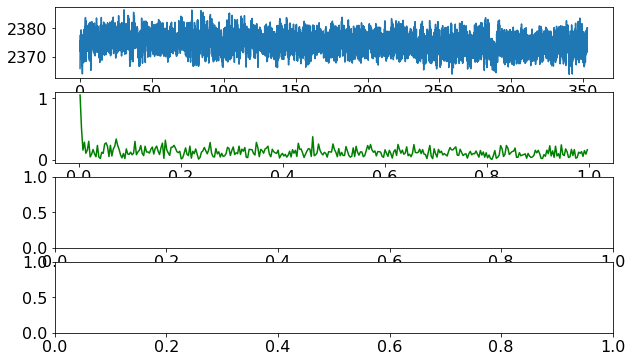

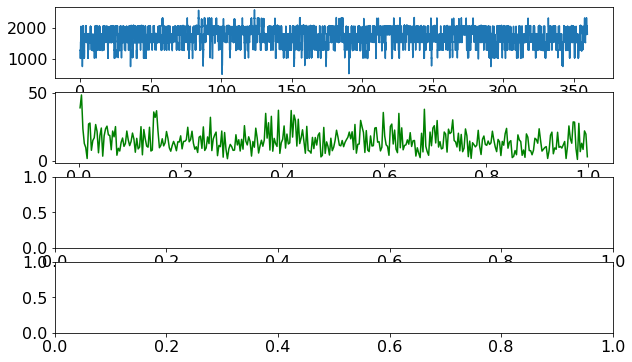

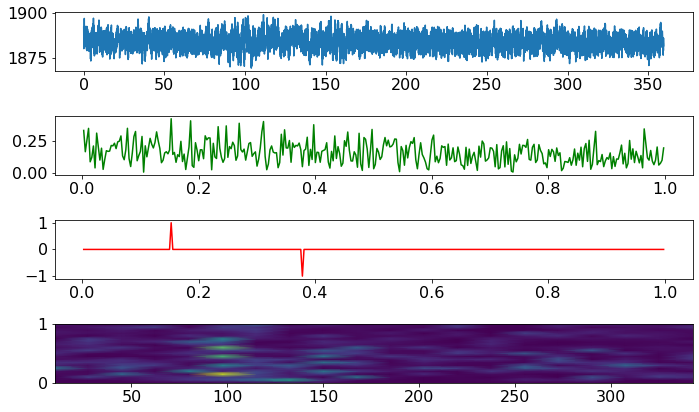

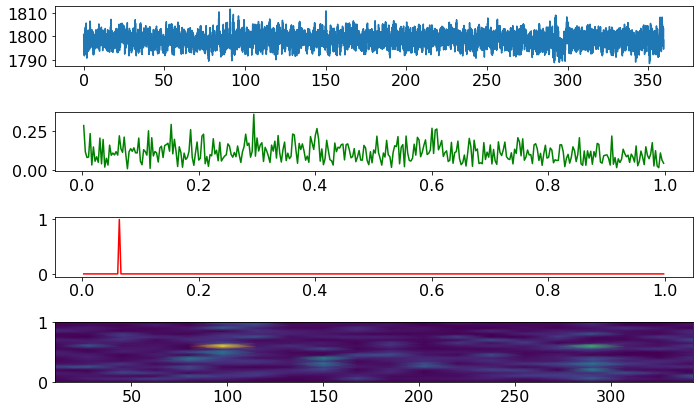

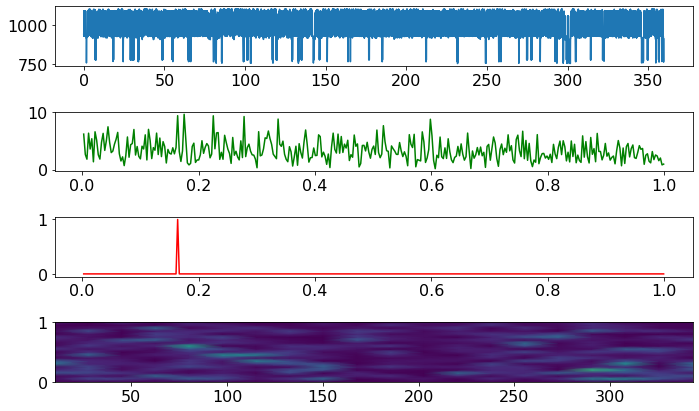

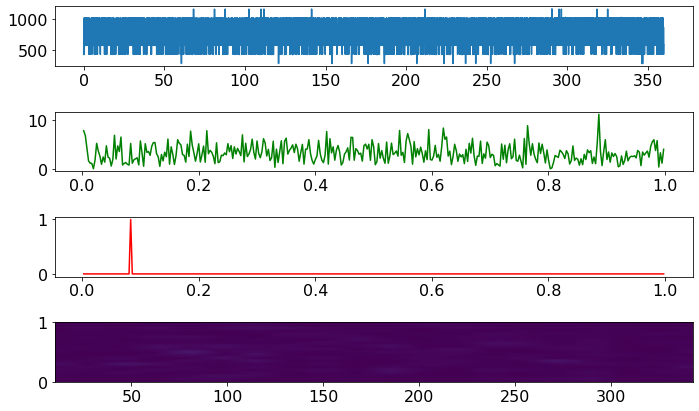

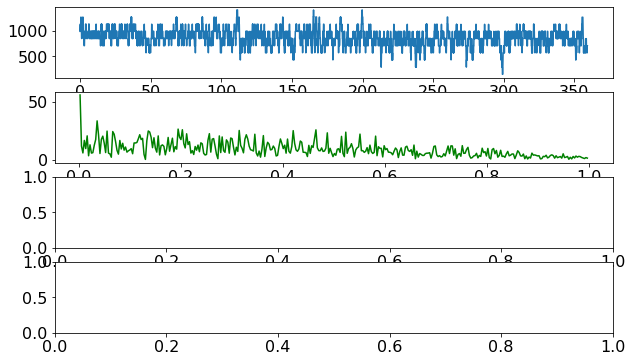

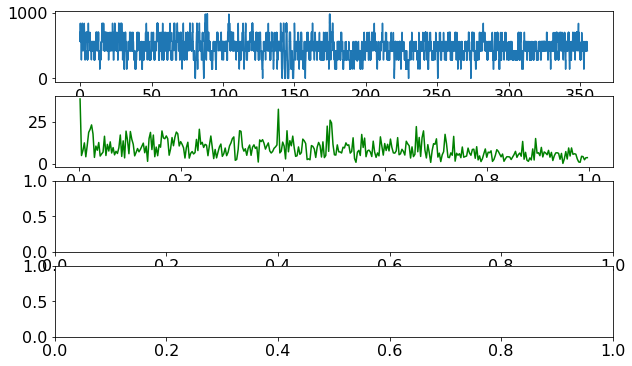

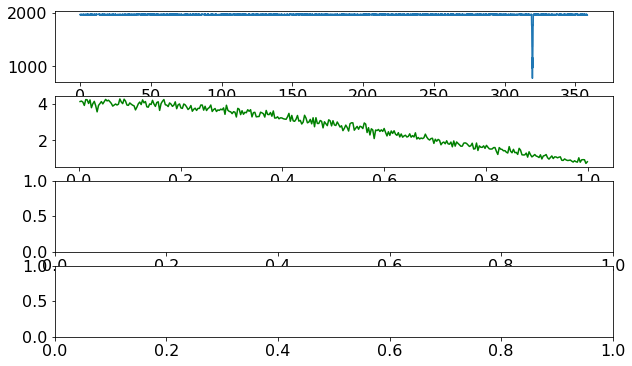

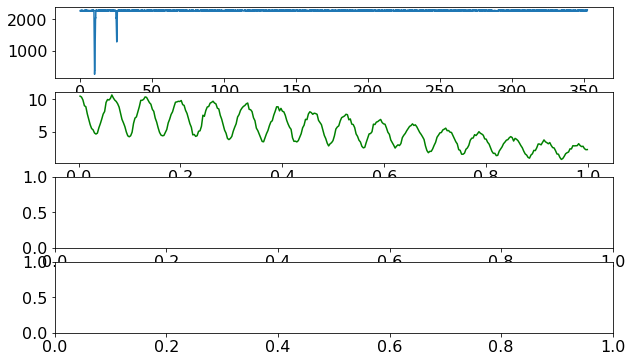

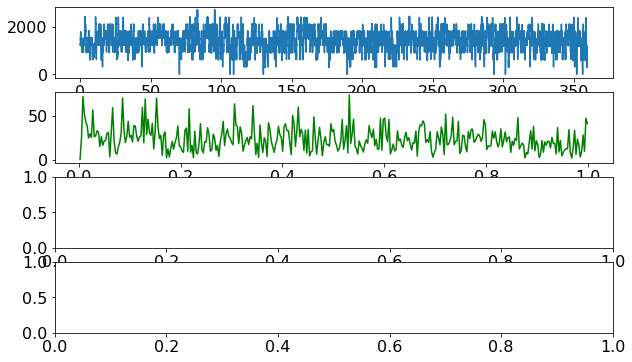

In [83]:
# RPLIDAR sleeping position 
# Aryan 30 BPM
# tidal breathing
#angle 270 - 282
#time: 180 seconds

df = pd.read_csv('tripod/30-BPM.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
elTime = 360 #time for which LIDAR was ON
stepAngle = 5
listofAngles = [(i,i+stepAngle) for i in range(0,360,stepAngle)]
for i in range(0,int(360/stepAngle)):
    try:
        startAngle, endAngle = listofAngles[i]
        sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
        selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
        t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
        #choose time stamp of data.
        startTime = 0 #in seconds
        timeUntil =  360 #in seconds
        selectedData = selectedData[startTime*sr:sr*timeUntil]
        t = t[startTime*sr:sr*timeUntil]
        #smooth the signal
        filter_window_size = 10
        dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
        t_ = t[:-filter_window_size+1]

        #get the frequency response
        F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
        fundamental = F[np.argmax(A[1:])+1]
        #if 0.2 <= fundamental <= 0.40:
        #print("SR = {}, Angle: {},{} Highest Freq Component {}".format(sr,startAngle,endAngle,fundamental))
        
        
        
        #get the peak of the signal
        peak_signal = thresholding_algo(A[1:resolution*1], 5, 8, 0)
        if np.where(peak_signal["signals"] == 1)[0].shape[0] == 1:
            print("Breathing found between {} and {}".format(startAngle, endAngle))
            #plot the figures
            fig, ax = plt.subplots(4,1, figsize=(10,6))
            ax[0].plot(t_,dist)
            resolution = int(round(len(F)/max(F)))
            ax[1].plot(F[1:resolution*1],A[1:resolution*1],color="green")
            ax[2].plot(F[1:resolution*1],peak_signal["signals"],color="red")
            f, t_s, Sxx = signal.spectrogram(np.array(dist), fs = sr, nperseg=sr*20)
            ax[3].pcolormesh(t_s, f, Sxx, shading='gouraud')
            ax[3].set_ylim(0,1)
        #print("Shape of input = {} and output = {}".format(A[1:resolution*1].shape,peak_signal["signals"].shape))
            fig.tight_layout()
     
    except Exception as e:
        print(e)

## LIDAR auto detect frequency where breathing can be captured
### Sleeping Positions

/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_23920/1790623960.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(3,1, figsize=(10,6))


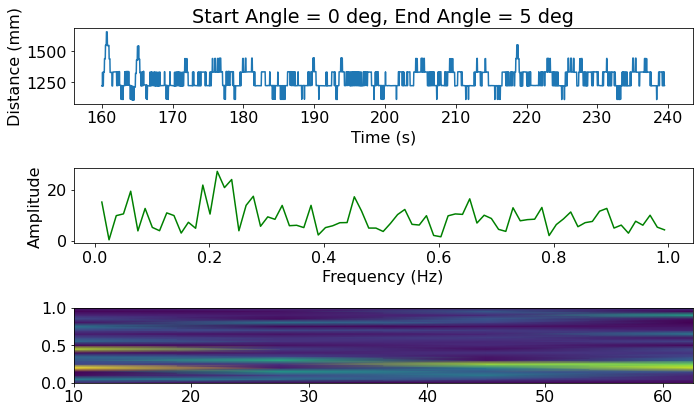

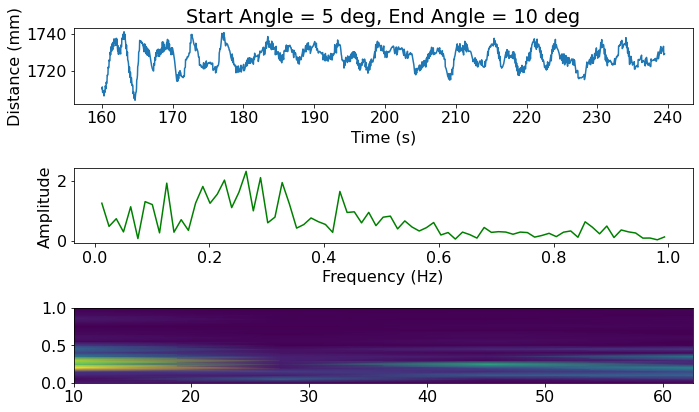

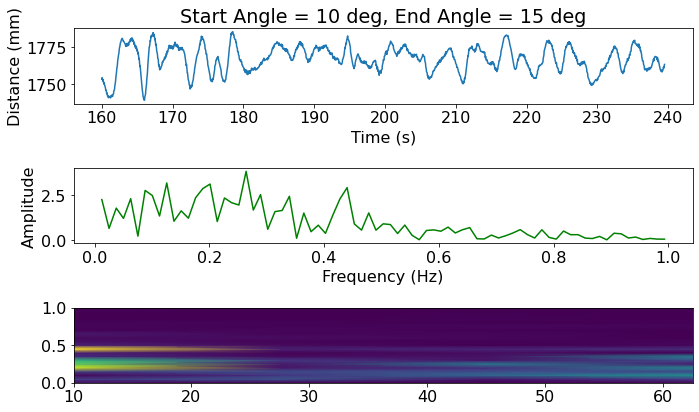

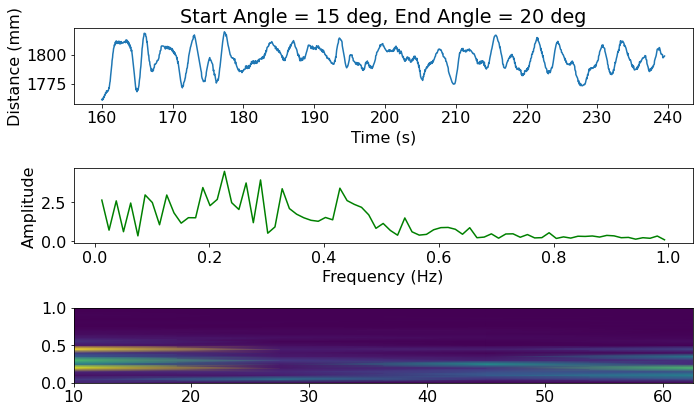

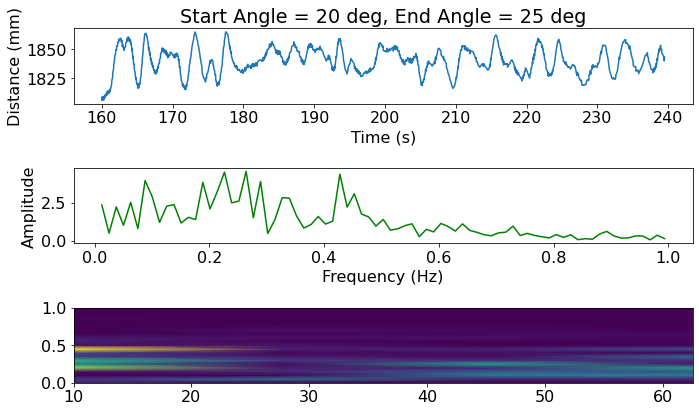

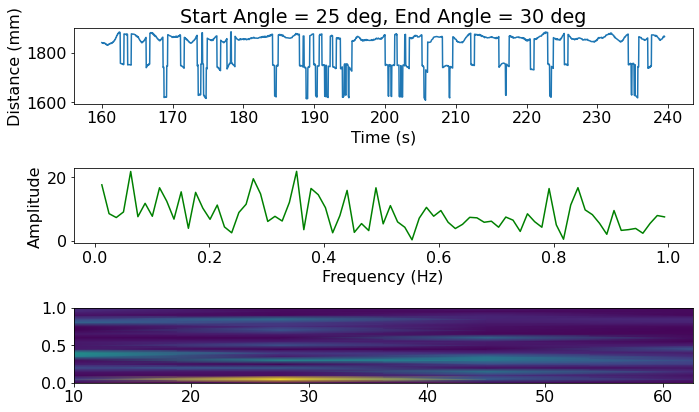

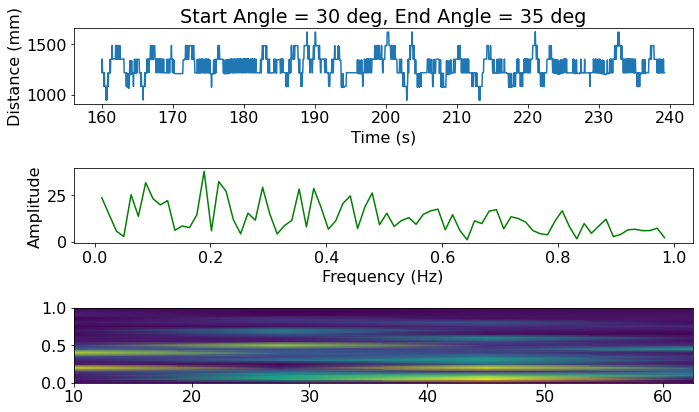

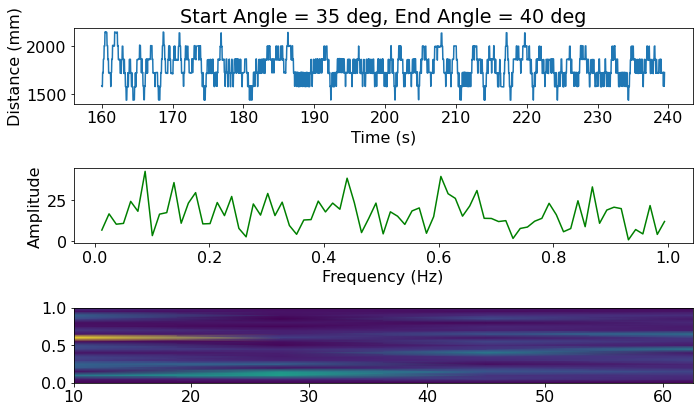

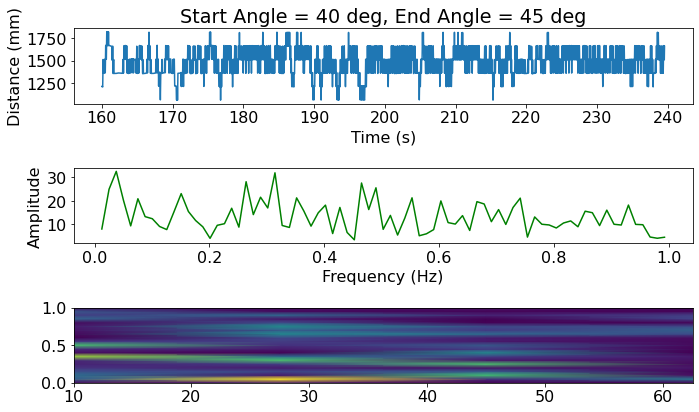

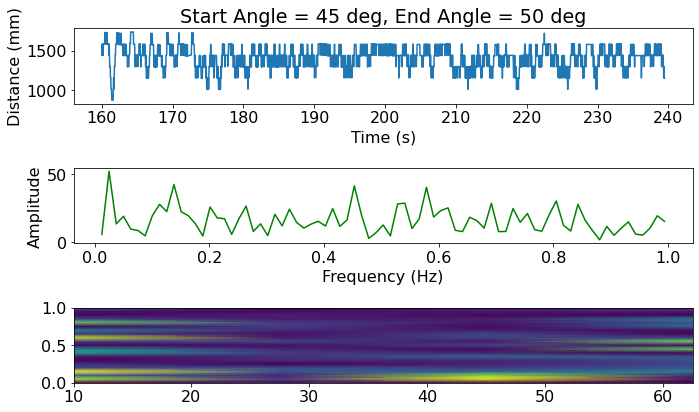

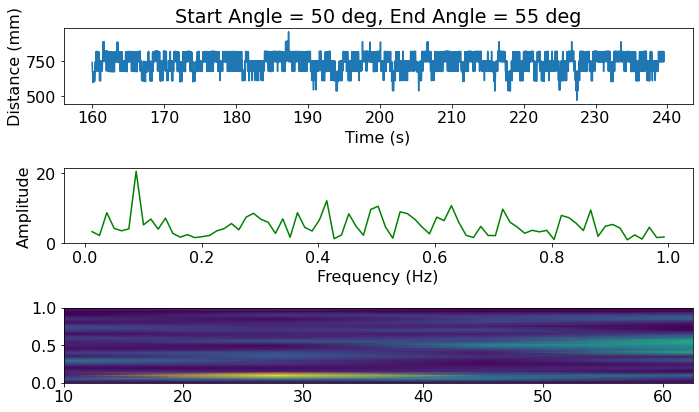

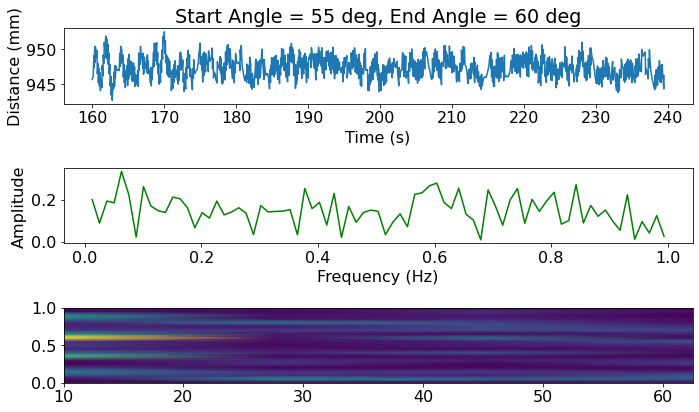

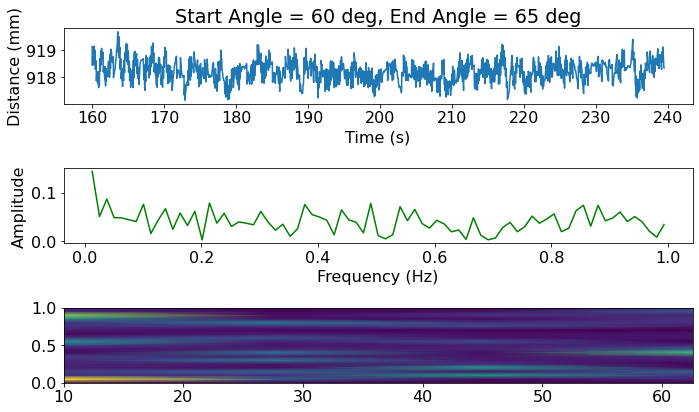

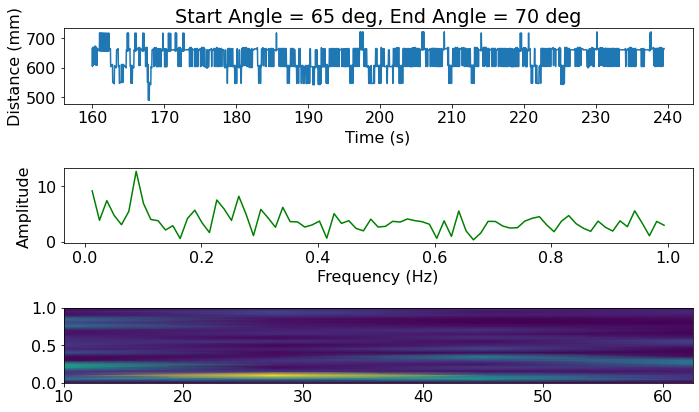

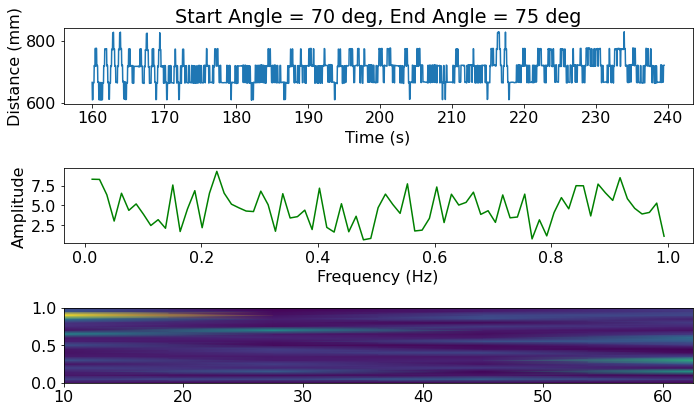

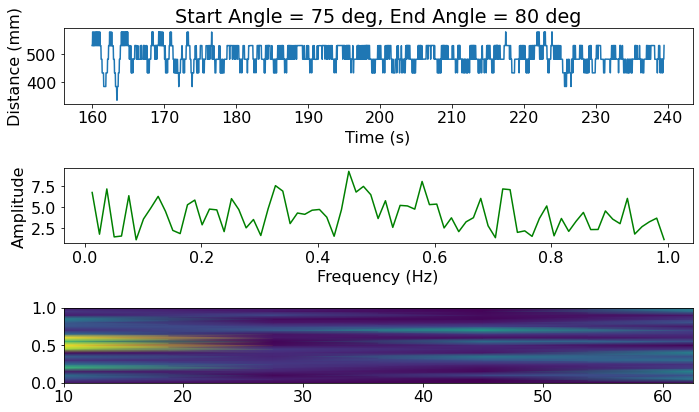

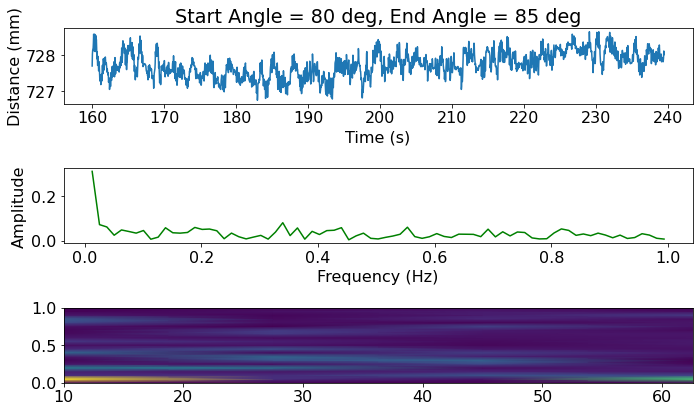

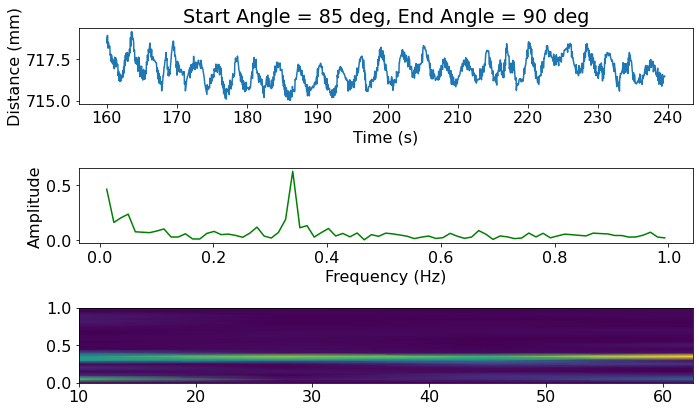

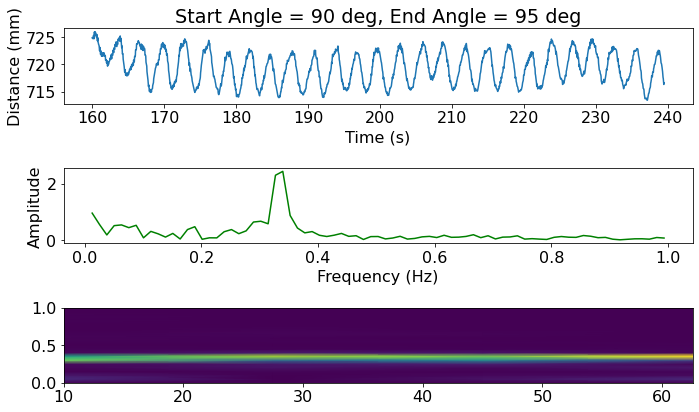

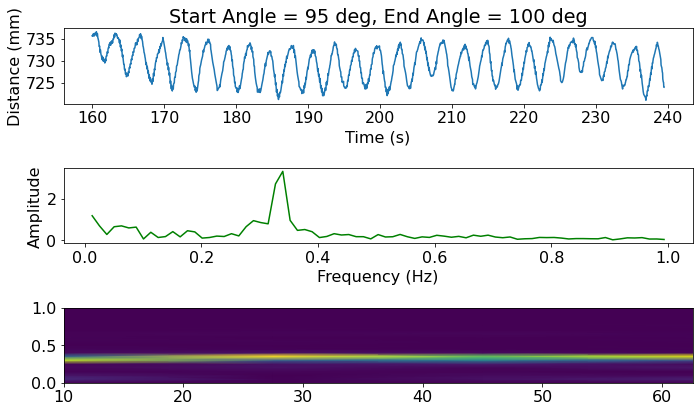

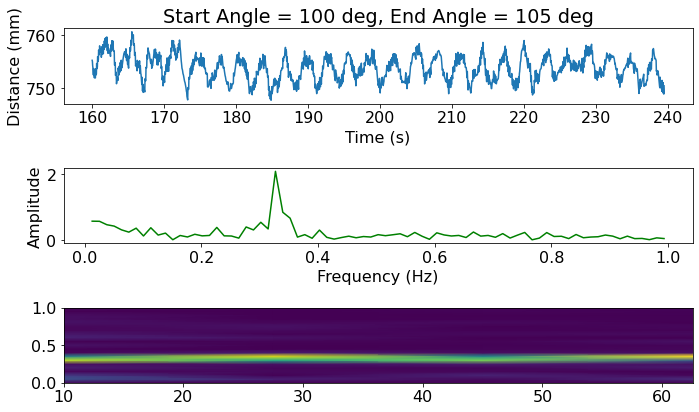

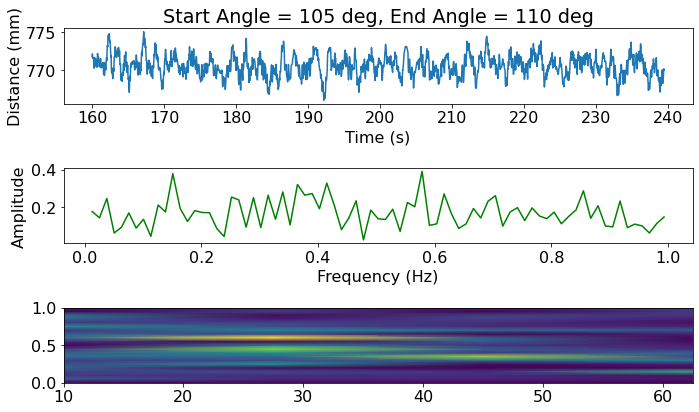

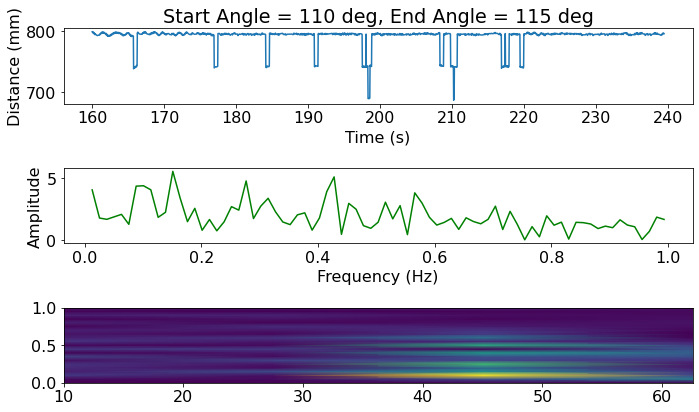

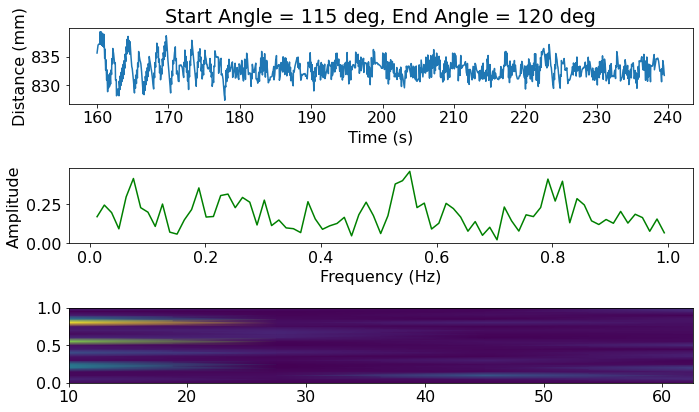

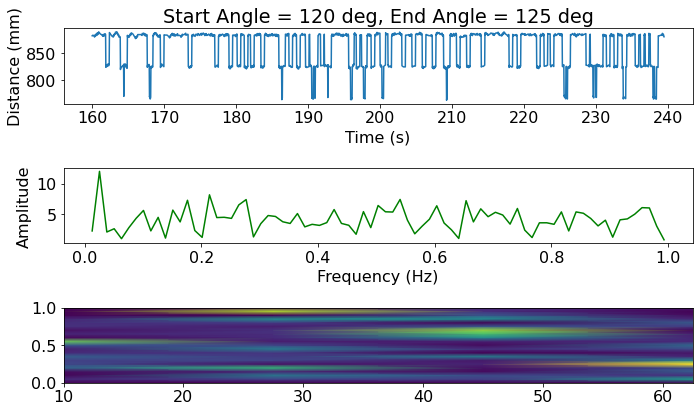

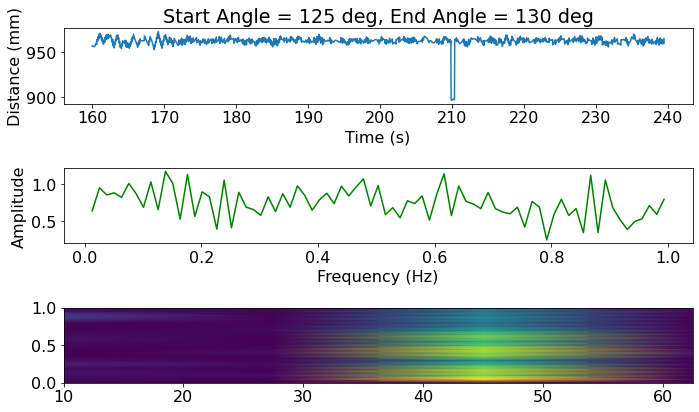

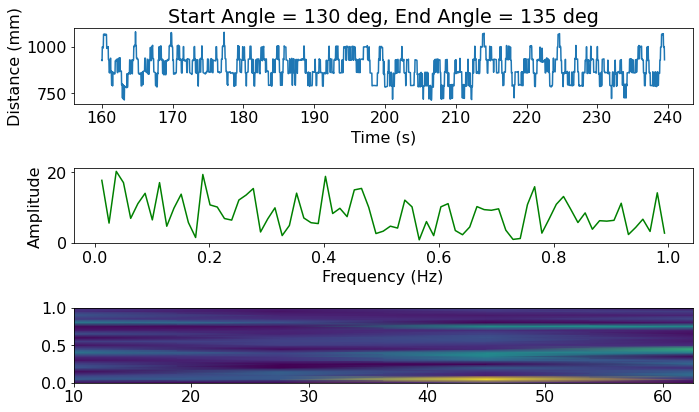

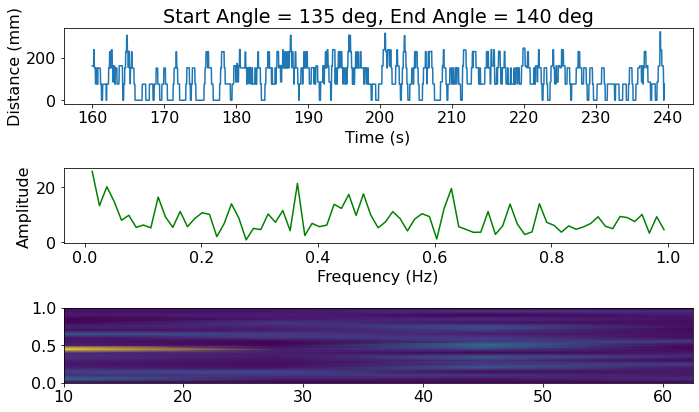

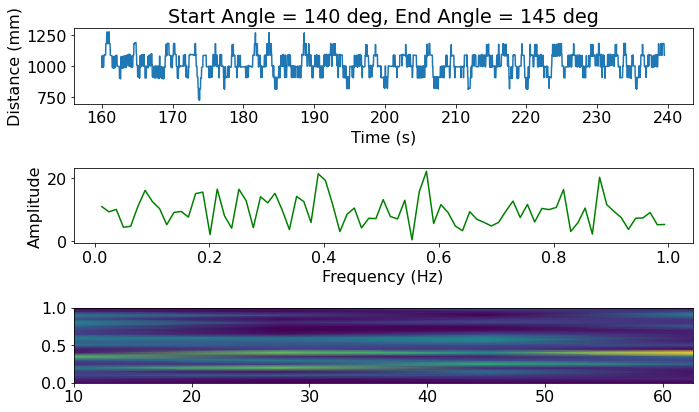

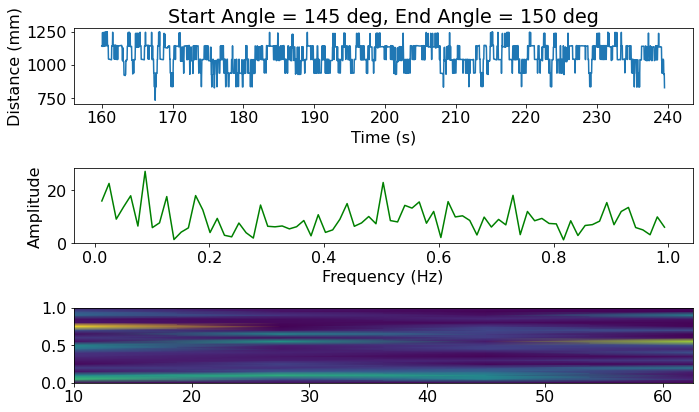

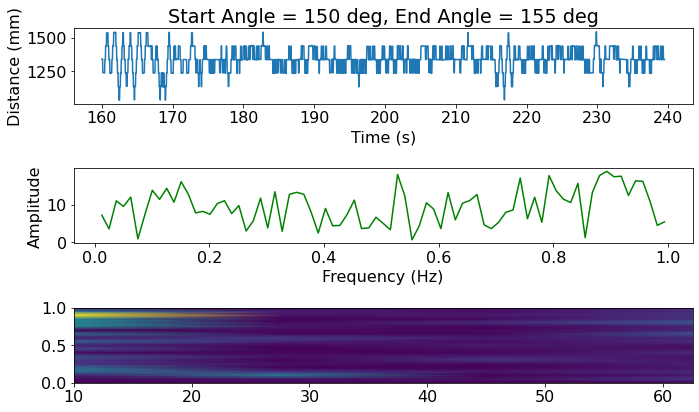

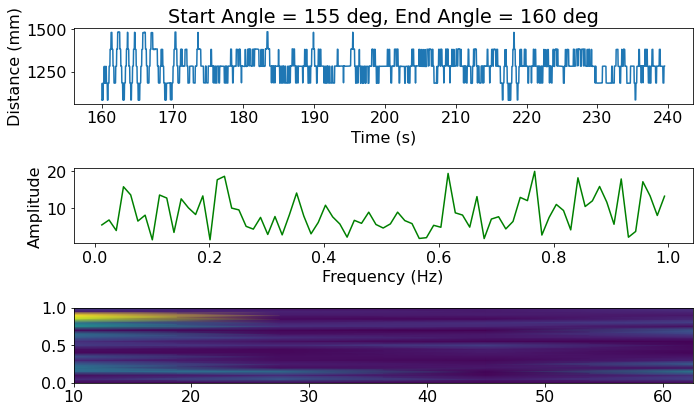

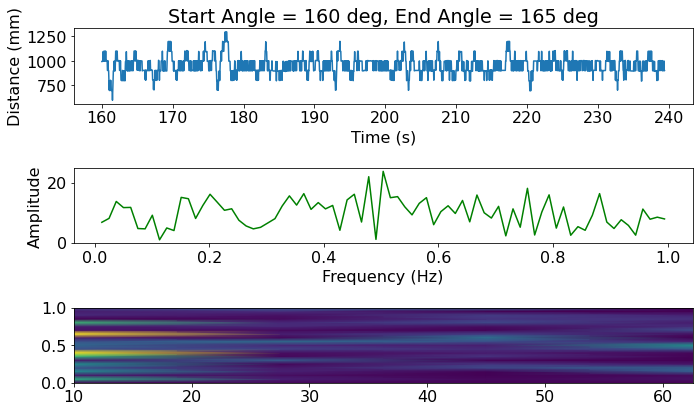

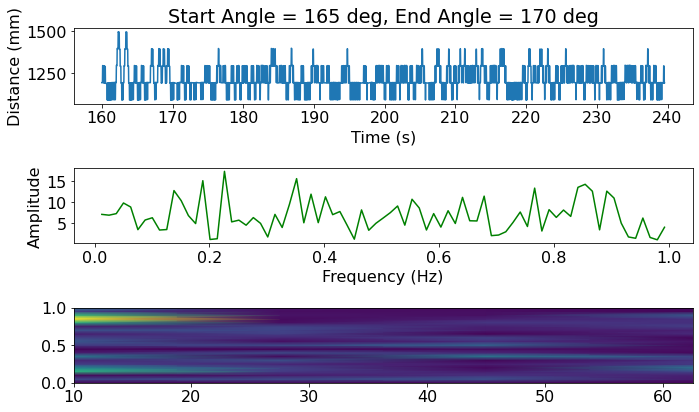

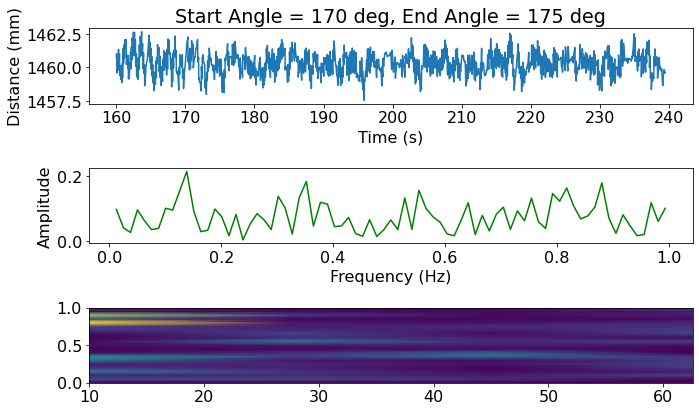

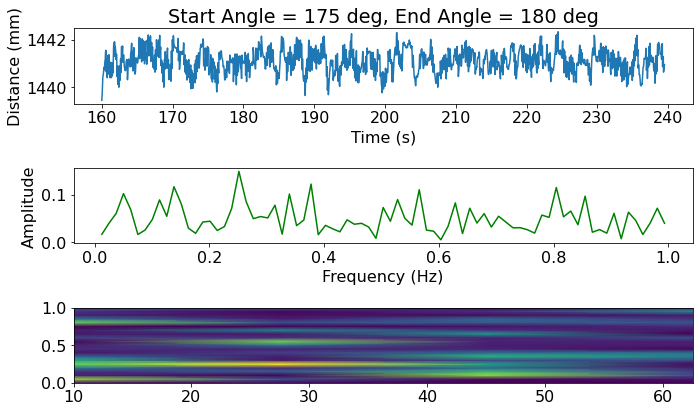

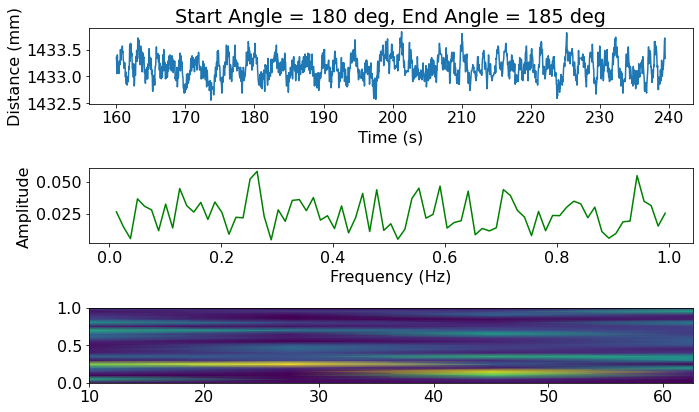

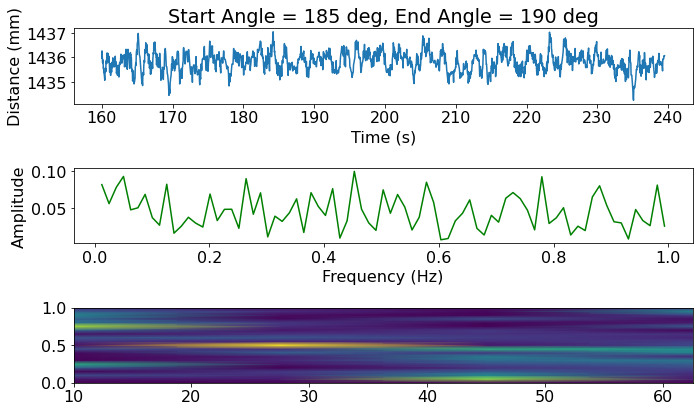

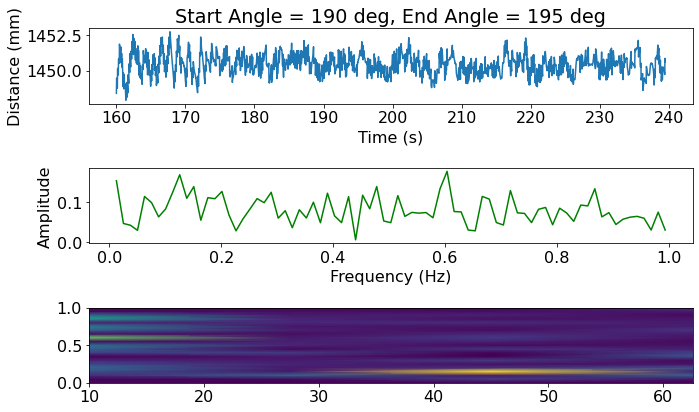

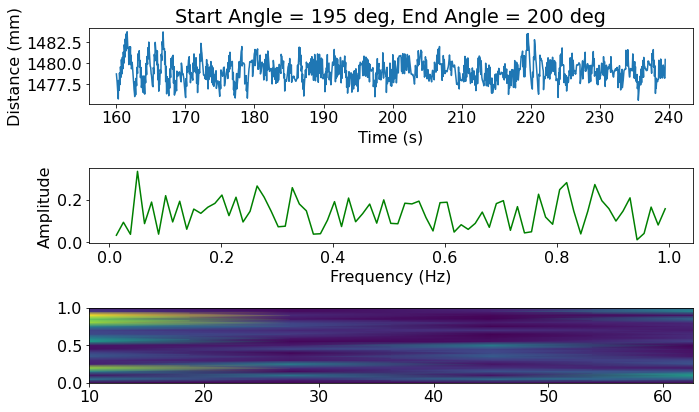

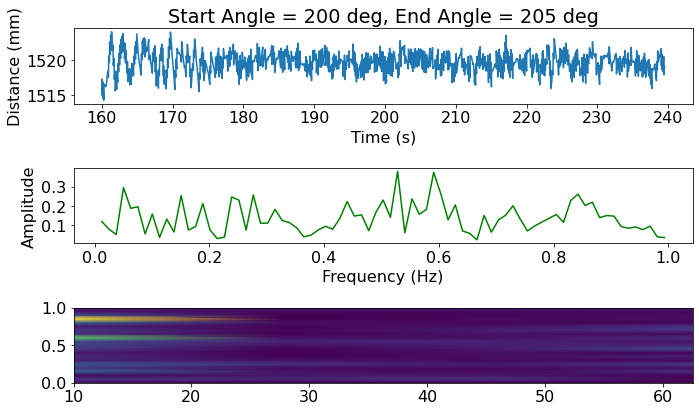

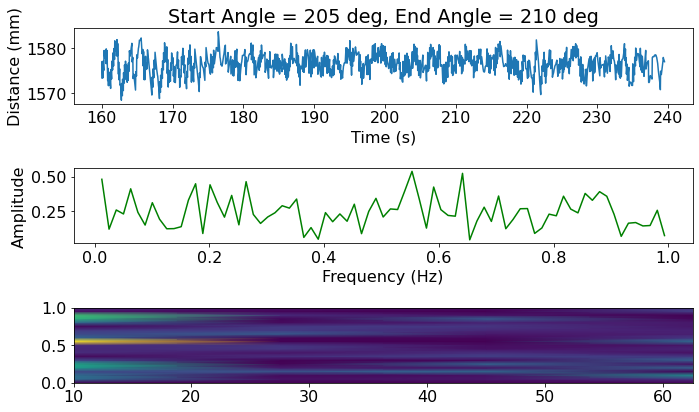

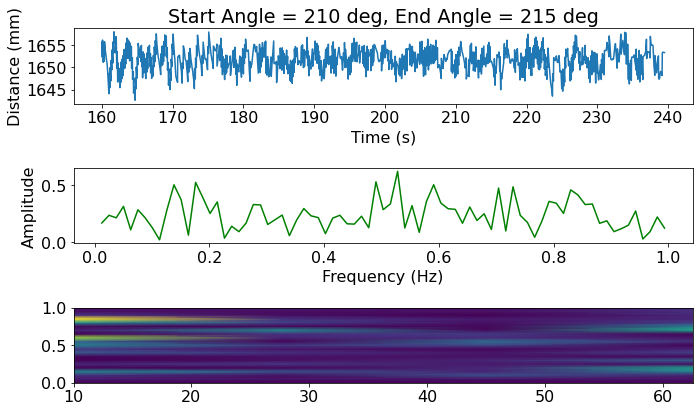

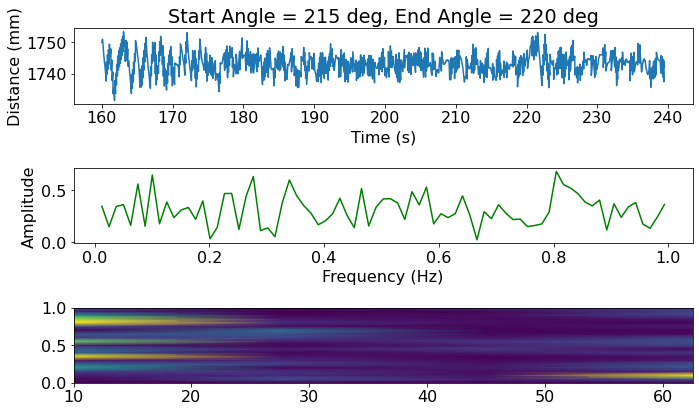

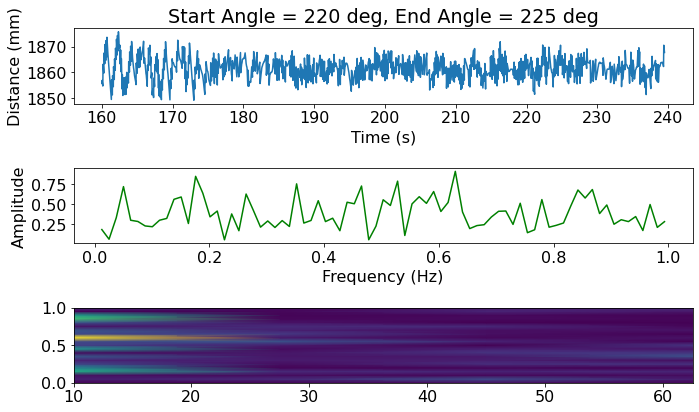

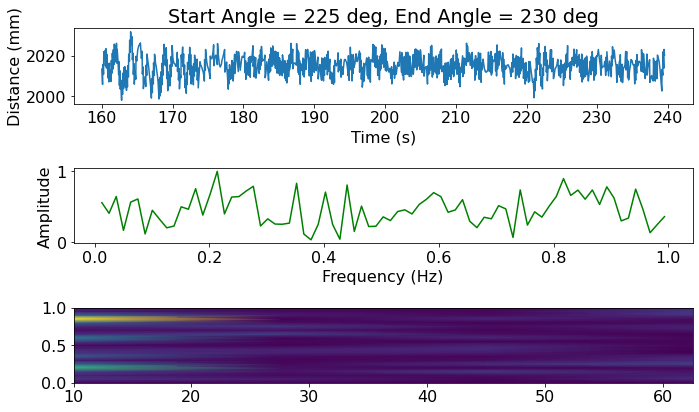

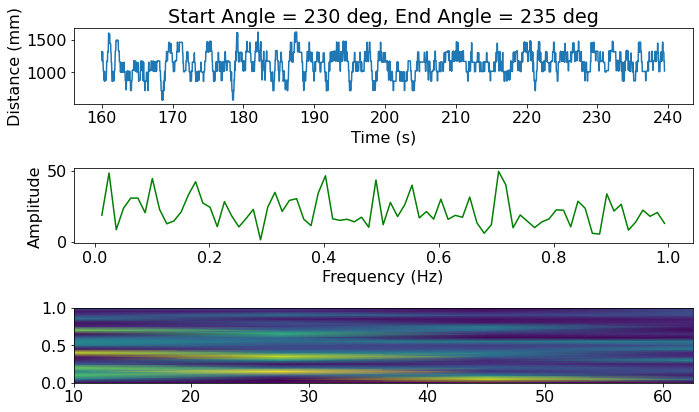

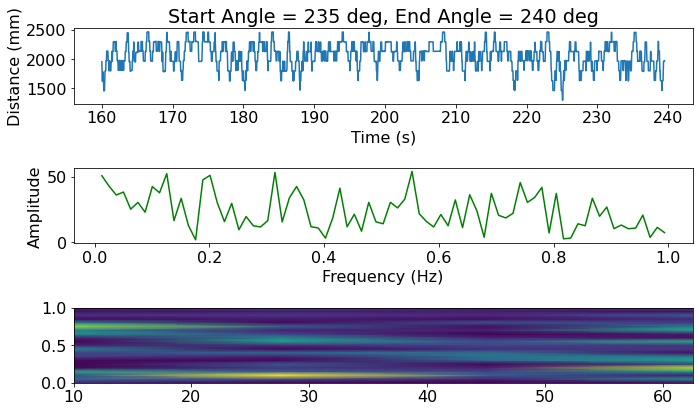

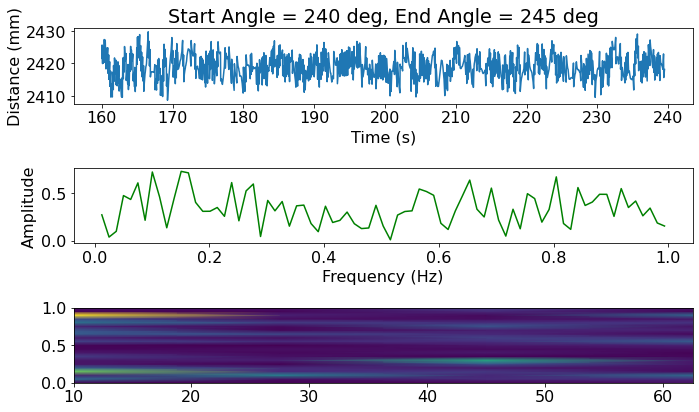

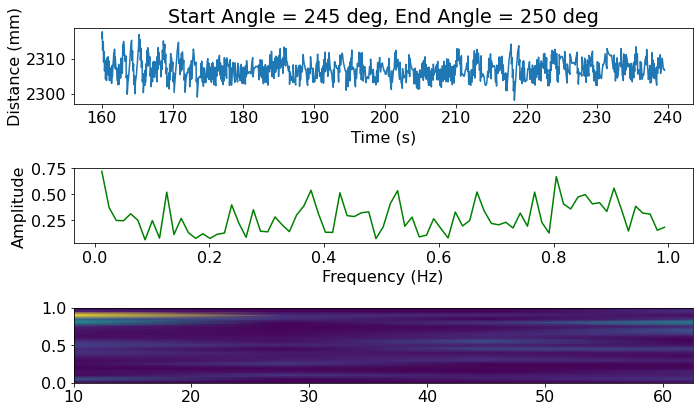

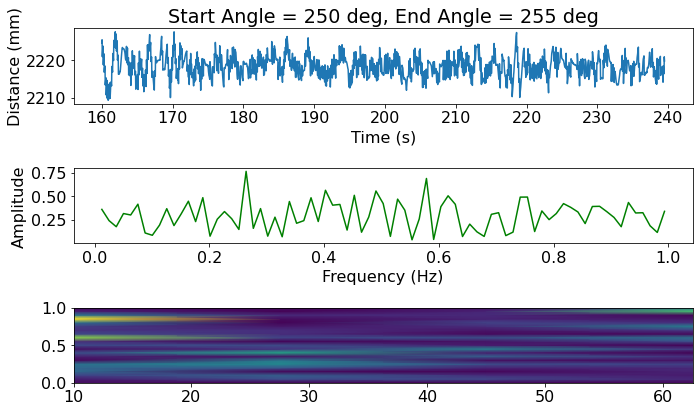

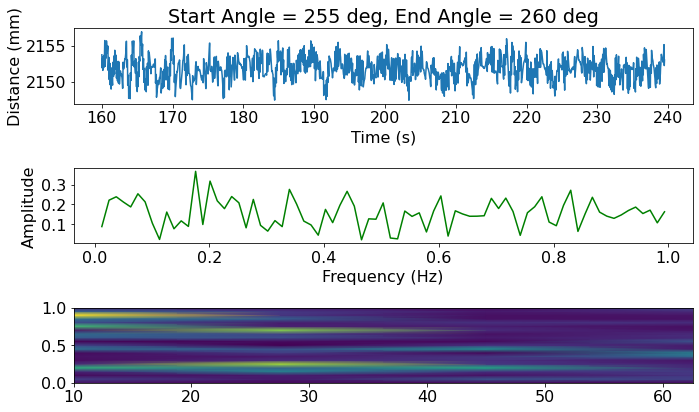

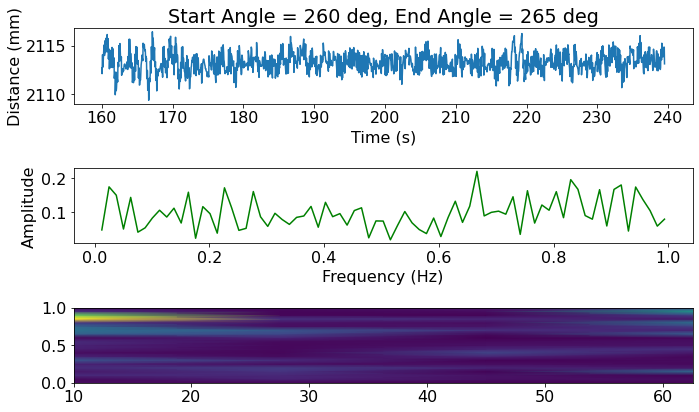

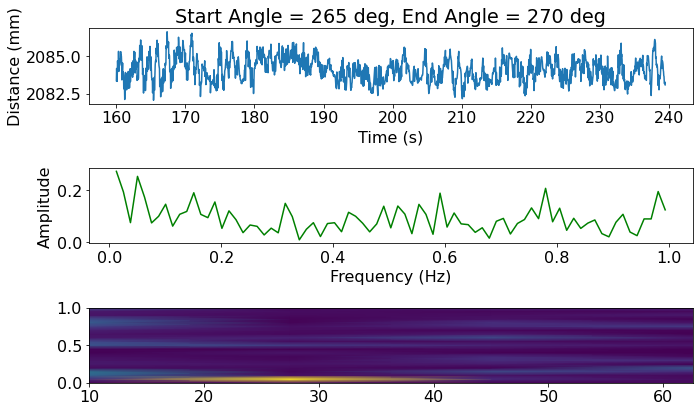

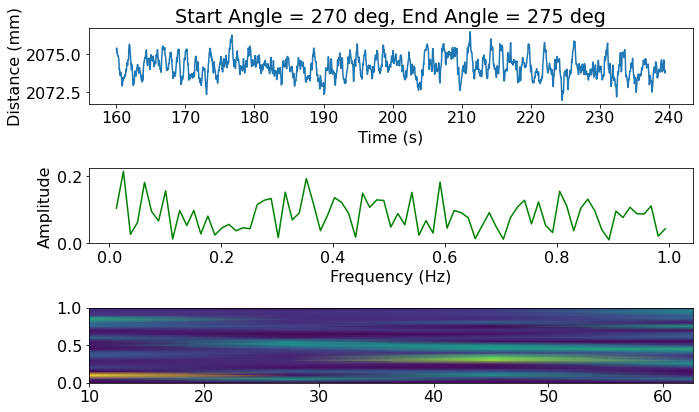

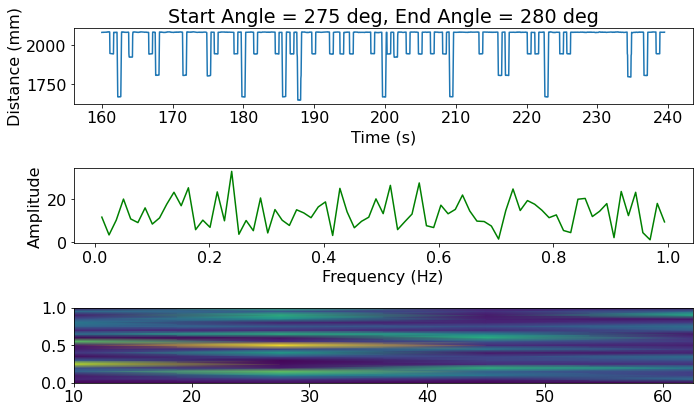

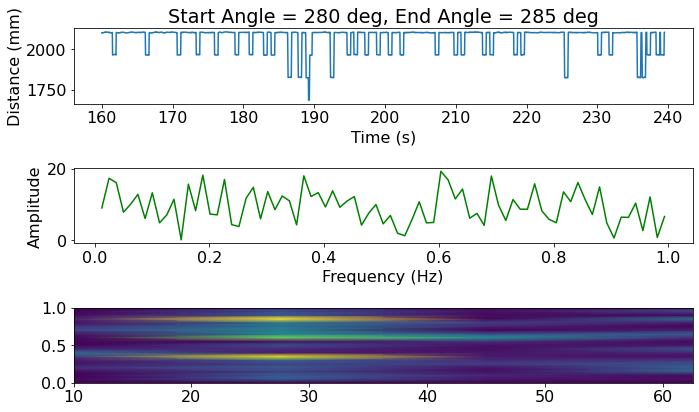

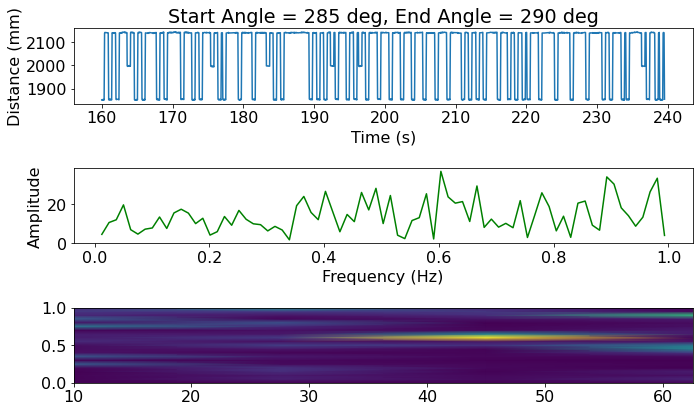

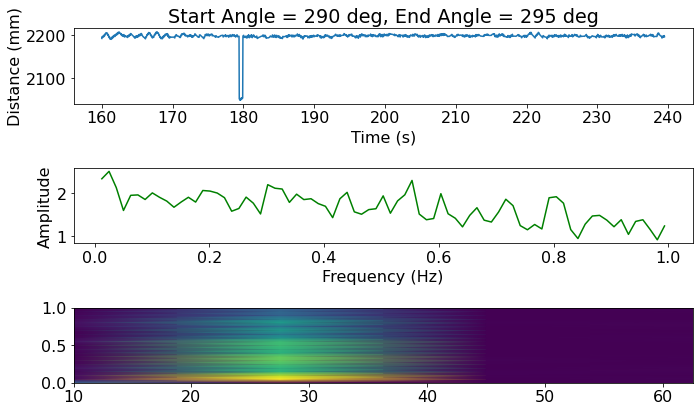

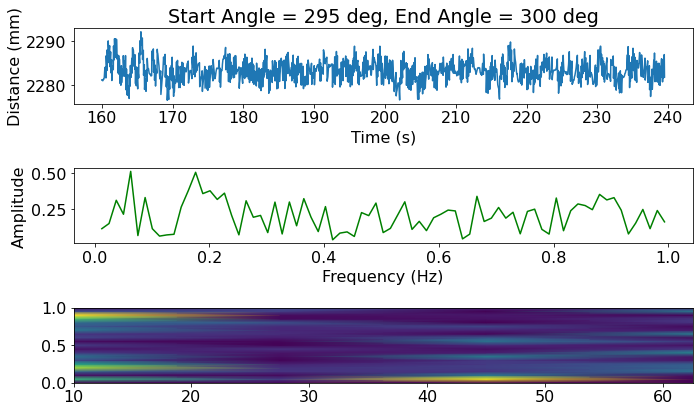

In [31]:
df = pd.read_csv('sleeping/6.csv', sep='\t',names=['New_Scan','Quality','Angle','Distance'])
elTime = 300 #time for which LIDAR was ON
stepAngle = 5
listofAngles = [(i,i+stepAngle) for i in range(0,elTime,stepAngle)]
for i in range(0,int(elTime/stepAngle)):
    try:
        startAngle, endAngle = listofAngles[i]
        sr = round((df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)].shape[0])/elTime)
        selectedData = df.loc[(df.Angle >= startAngle) & (df.Angle <= endAngle)]
        t= [x/sr for x in range(0,selectedData['Distance'].shape[0])]
        #choose time stamp of data.
        startTime = 160 #in seconds
        timeUntil =  240 #in seconds
        selectedData = selectedData[startTime*sr:sr*timeUntil]
        t = t[startTime*sr:sr*timeUntil]
        #smooth the signal
        filter_window_size = 15
        dist = np.convolve(selectedData['Distance'] , np.ones((filter_window_size,))/filter_window_size, mode='valid')
        t_ = t[:-filter_window_size+1]

        #get the frequency response
        F,A = compute_fft(np.array(dist), sr, n = None, scale_amplitudes = True)
        fundamental = F[np.argmax(A[1:])+1]
        #if 0.2 <= fundamental <= 0.40:
        #print("SR = {}, Angle: {},{} Highest Freq Component {}".format(sr,startAngle,endAngle,fundamental))
        
        
        
        #get the peak of the signal
        #peak_signal = thresholding_algo(A[1:resolution*1], 5, 8, 0)
        #if np.where(peak_signal["signals"] == 1)[0].shape[0] == 1:
            #print("Breathing found between {} and {}".format(startAngle, endAngle))
        #plot the figures
        fig, ax = plt.subplots(3,1, figsize=(10,6))
        ax[0].plot(t_,dist)
        ax[0].set_title("Start Angle = {} deg, End Angle = {} deg".format(startAngle,endAngle))
        ax[0].set_xlabel("Time (s)")
        ax[0].set_ylabel("Distance (mm)")
        resolution = int(round(len(F)/max(F)))
        ax[1].plot(F[1:resolution*1],A[1:resolution*1],color="green")
        ax[1].set_ylabel("Amplitude")
        ax[1].set_xlabel("Frequency (Hz)")
        #ax[2].plot(F[1:resolution*1],peak_signal["signals"],color="red")
        f, t_s, Sxx = signal.spectrogram(np.array(dist), fs = sr, nperseg=sr*20)
        ax[2].pcolormesh(t_s, f, Sxx, shading='gouraud')
        ax[2].set_ylim(0,1)
    #print("Shape of input = {} and output = {}".format(A[1:resolution*1].shape,peak_signal["signals"].shape))
        fig.tight_layout()
     
    except Exception as e:
        print(e)